In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astroquery.utils.tap.core import TapPlus
import astropy.io.votable
from astropy.timeseries import LombScargle
import time as Time
import random
from astropy import units as u
import pandas as pd
from astropy.table import table as Table

In [2]:
gaia = TapPlus(url="https://gea.esac.esa.int/tap-server/tap")

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [3]:
from joblib import Memory
cachedir = '../joblib_cache'
memory = Memory(cachedir, verbose=0, bytes_limit=1e7)
@memory.cache
def get_gaia_query(q,output=False,output_file=None,output_format=None):
    start = Time.time()
    job = gaia.launch_job_async(q,dump_to_file=output,output_file=output_file,output_format=output_format)
    print(f"Total time of getting gaia data: {Time.time()-start:0.2f} sec")
    return job.get_results()

In [4]:
@memory.cache
def get_astro_table(url):
    start = Time.time()
    votable = astropy.io.votable.parse(url)
    table = votable.get_first_table().to_table(use_names_over_ids=True)
    print(f"Total time of getting astro table: {Time.time()-start:0.2f} sec")
    return table

In [5]:
def get_col(table,colname):
    '''
    This function returns columns with given columns' names.
    
    colname: list of strings
    '''
    col = []
    for i in colname:
        c = np.array(table[i])
        col.append(c)
    return col

In [6]:
def get_dataframe(job,source_id=None,table=None,colname=None):
    '''
    This function is use to turn a astro table a pandas dataframe which "phase" is in order and with information of its pf and omega.
    
    job: result returned by get_gaia_query().
        Use to identify which job result to use.
    
    source_id/table: one of which must be given to get a result.
    
    If colname is given, this function also returns columns with given columns' names in the form of list.
    '''
    if table is None:
        source = int(np.where(job['source_id']==sourceid)[0])
        url = job["epoch_photometry_url"][source]
        table = get_astro_table(url)
        table = table[np.where(table['band']=="G")]
        table = table.to_pandas()
    else:
        source = int(np.where(job['source_id']==table['source_id'][0])[0])
        table = table.to_pandas()

    if len(job)==100:
        pf = job['pf'][source]
#         pf = pfs_rrab[source]
        omega = 2*np.pi/pf
        phase = np.array(table['time'])%pf
    if len(job)==3:
        pf = job['p1_o'][source]
#         pf = pfs_rrc[source]
        omega = 2*np.pi/pf
        phase = np.array(table['time'])%pf

    table['phase'] = phase
    table['pf']= pf
    table['omega'] = omega
    table = table.sort_values('phase')
    table.index = range(len(table))
    
    if colname is None:
        return table
    else:
        col = []
        for i in colname:
            c = np.array(table[i])
            col.append(c)
        return table,col

# Problem 1

## 1

In [7]:
query_1 = '''SELECT TOP 100 *
            FROM gaiadr2.vari_rrlyrae 
            JOIN gaiadr2.gaia_source as gaia USING (source_id)
            WHERE vari_rrlyrae.pf IS NOT NULL 
            AND vari_rrlyrae.num_clean_epochs_g > 40'''

In [8]:
job1 = get_gaia_query(query_1)

job1[:10]

solution_id,pf,pf_error,p1_o,p1_o_error,p2_o,p2_o_error,p3_o,p3_o_error,epoch_g,epoch_g_error,epoch_bp,epoch_bp_error,epoch_rp,epoch_rp_error,int_average_g,int_average_g_error,int_average_bp,int_average_bp_error,int_average_rp,int_average_rp_error,peak_to_peak_g,peak_to_peak_g_error,peak_to_peak_bp,peak_to_peak_bp_error,peak_to_peak_rp,peak_to_peak_rp_error,metallicity,metallicity_error,r21_g,r21_g_error,r31_g,r31_g_error,phi21_g,phi21_g_error,phi31_g,phi31_g_error,num_clean_epochs_g,num_clean_epochs_bp,num_clean_epochs_rp,g_absorption,g_absorption_error,best_classification,solution_id_2,designation,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,source_id
,d,d,d,d,d,d,d,d,d,d,d,d,d,d,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,dex,dex,,,,,rad,rad,rad,rad,,,,mag,mag,,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / mas2,1 / um,1 / um,,,,mas,,,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,Rsun,Rsun,Rsun,Lsun,Lsun,Lsun,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,object,int64,object,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int32,int16,bool,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,int32,float32,float32,float32,object,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,object,object,int64
369295551293819386,0.45207240076998667,1.3003196171988113e-06,--,--,--,--,--,--,1700.6320136814795,1.8389296380623503e-06,1783.0270727437294,1.8389296380623503e-06,1783.019968286169,1.8389296380623503e-06,19.829002378100697,0.0017611118938539022,20

## 2

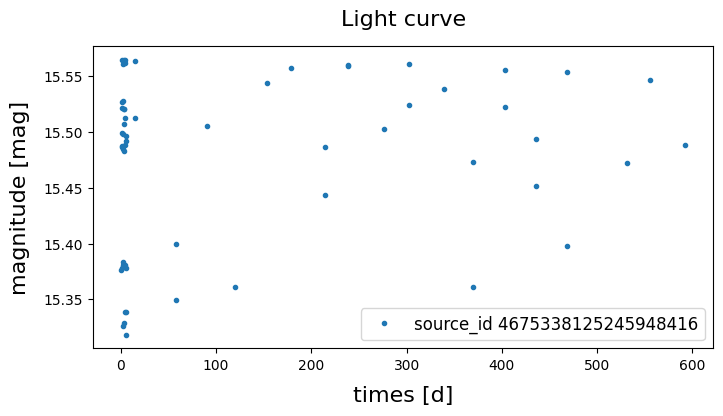

In [9]:
random.seed(3)
source = random.randint(0,99)

url = job1["epoch_photometry_url"][source]
table = get_astro_table(url)
table = table[np.where(table['band']=="G")]

fig = plt.figure(figsize=(8,4),dpi=100)
plt.plot(table['time']-int(table['time'][0]),table['mag'],'.',label="source_id "+str(table['source_id'][0]),)
plt.xlabel('times [d]',fontsize=16,labelpad=10)
plt.ylabel('magnitude [mag]',fontsize=16,labelpad=10)
plt.title("Light curve",fontsize=16,pad=15)
plt.legend(fontsize=12)
plt.show()

## 3

### Get 100 light curve data

In [10]:
tables_rrab = []
for source in range(len(job1)):
    url = job1["epoch_photometry_url"][source]
    table = get_astro_table(url)
    table = table[np.where(table['band']=="G")]
    tables_rrab.append(table)
    print("The light curve of the",source,"source has been added.")

The light curve of the 0 source has been added.
The light curve of the 1 source has been added.
The light curve of the 2 source has been added.
The light curve of the 3 source has been added.
The light curve of the 4 source has been added.
The light curve of the 5 source has been added.
The light curve of the 6 source has been added.
The light curve of the 7 source has been added.
The light curve of the 8 source has been added.
The light curve of the 9 source has been added.
The light curve of the 10 source has been added.
The light curve of the 11 source has been added.
The light curve of the 12 source has been added.
The light curve of the 13 source has been added.
The light curve of the 14 source has been added.
The light curve of the 15 source has been added.
The light curve of the 16 source has been added.
The light curve of the 17 source has been added.
The light curve of the 18 source has been added.
The light curve of the 19 source has been added.
The light curve of the 20 sour

### Estimate period
* **From google we know that the period of RR Lyrae 4 hours to 1 day.**

In [11]:
fmax = 1/((4/24)) 
fmin = 1/(1)

* **Get periods of 100 light curves and the difference between periods calculated by DFT and PF Gaia given.**

In [12]:
pfs_rrab = []
for source in range(len(job1)):  
    table = tables_rrab[source]
    
    t,flux,fluxerr,mag = get_col(table,['time','flux','flux_error','mag'])

    freq, power = LombScargle(t, flux,dy=fluxerr).autopower(minimum_frequency=fmin,maximum_frequency=fmax)
    pf = 1/freq[np.argmax(power)]
    pfs_rrab.append(pf)

* **Plot the periodogram for one light curve.**

In [13]:
def plot_periodogram(table,job):
    table = table[np.where(table['band']=="G")]
    
    t,flux,flux_er,mag = get_col(table,['time','flux','flux_error','mag'])
    error = 2.5*np.log10(flux_er)

    freq, power = LombScargle(t, mag,dy=error).autopower(minimum_frequency=fmin,maximum_frequency=fmax)
    pf = 1/freq[np.argmax(power)]

    fig = plt.figure(figsize=(8,4),dpi=120)
    plt.plot(freq, power,'k',label='power spectrum')
    plt.plot(freq[np.where(abs(freq-(1/job['pf'][source]))<5e-4)],
             list(power[np.where(abs(freq-(1/job['pf'][source]))<5e-4)][1:])+[0],'b',
             label=r"$PF_{gaia}=$"+str(round(job['pf'][source],3))+"d")
    plt.plot(freq[np.argmax(power)-1:np.argmax(power)+1],[0]+[np.max(power)],'r--',
             label=r"$PF_{dft}=$"+str(round(pf,3))+"d")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(r"frequency $[d^{-1}]$",fontsize=15,labelpad=5)
    plt.ylabel('power',fontsize=15,labelpad=10)
    plt.legend(fontsize=12)
    plt.title("Pieriodogram of source id "+str(table['source_id'][0]),fontsize=16,pad=13)
    plt.show()

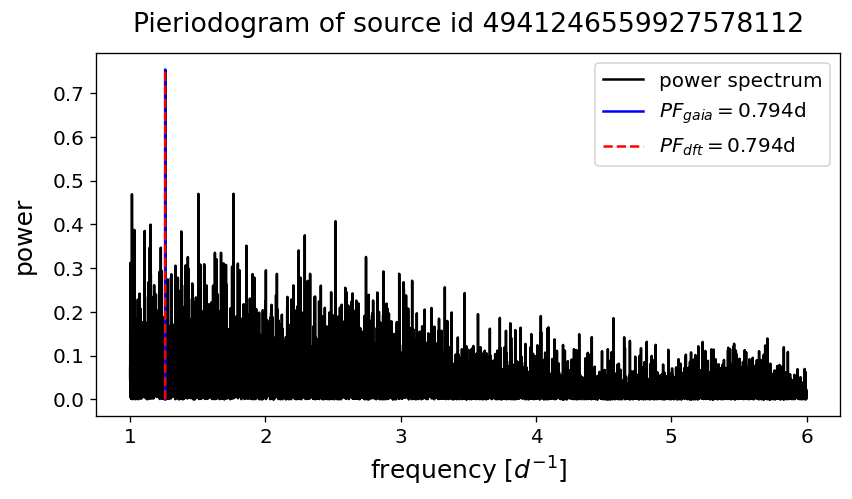

In [14]:
random.seed(44)
source = random.randint(0,99)

url = job1["epoch_photometry_url"][source]
table = get_astro_table(url)
plot_periodogram(table,job1)

### Estimate mean magnitude

* **From Pugsons Law, we have,**

$$m_1 - m_2 = 2.5 log(I_2/I_1)$$

* **Therefore we can calculate the mean flux of the 100 light curves and use this equation to obtain the mean magnitude.**

In [15]:
mag_means_rrab = []
for table in tables_rrab:  
    flux_mean = table['flux'].mean()
    mag_mean = table['mag'][0]+2.5*np.log10(table['flux'][0]/flux_mean)
    mag_means_rrab.append(mag_mean)

* ** The variable *tables_rrab, mag_means_rrab, pfs_rrab* could be used in the following analysis.**

## 4

###  Compare the periods computed from the 100 light curves to the values reported in the vari_rrlyrae catalog

In [16]:
def plot_compare_residual(x,y,quantity,units,n=5):
    ploty,ylabel = y
    if len(x)==2:
        plotx,xlabel = x
        diffs = []
        for source in range(len(plotx)):  
            diff = plotx[source]-ploty[source]
            diffs.append(diff)
    else:
        plotx,xlabel,plotx2,xlabel2 = x
        diffs = []
        for source in range(len(plotx)):  
            diff = plotx[source]-ploty[source]
            diffs.append(diff)
        diffs2 = []
        for source in range(len(plotx)):  
            diff = plotx2[source]-ploty[source]
            diffs2.append(diff)


    axis1min = min(np.min(plotx),np.min(ploty))-0.1*(max(np.max(plotx),np.max(ploty))-min(np.min(plotx),np.min(ploty)))
    axis1max = max(np.max(plotx),np.max(ploty))+0.1*(max(np.max(plotx),np.max(ploty))-min(np.min(plotx),np.min(ploty)))
    axis2min = -max(abs(np.max(diffs)),abs(np.min(diffs)))-2*abs(max(abs(np.max(diffs)),abs(np.min(diffs))))/n
    axis2max = max(abs(np.max(diffs)),abs(np.min(diffs)))+2*abs(max(abs(np.max(diffs)),abs(np.min(diffs))))/n

    fig = plt.figure(figsize=(8,10),dpi=100)
    ax1 = plt.axes([0.15, 0.35, 0.8, 0.5])
    plt.plot(np.linspace(int(axis1min),int(axis1max)+1),np.linspace(int(axis1min),int(axis1max)+1),'k--',linewidth=1)
    plt.plot(plotx,ploty,'.',color='darkred',alpha=0.9,markersize=10,label=xlabel)
    if len(x) != 2:
        plt.plot(plotx2,ploty,'.',color='darkgreen',alpha=0.5,markersize=10,label=xlabel2)
        plt.legend(fontsize=18,loc=4)
    plt.xlim(axis1min,axis1max)
    plt.ylim(axis1min,axis1max)
    plt.ylabel(ylabel+' ['+units+']',fontsize=20,labelpad=20)
    plt.xticks(visible=False)
    plt.yticks(fontsize=18)
    plt.title("Compare "+quantity,fontsize=22,pad=13)
    ax2 = plt.axes([0.15, 0.14, 0.8, 0.2])
    plt.axhline(0,linestyle='--',color='k',linewidth=1)
    plt.plot(plotx,diffs,'.',markersize=8)
    plt.xlabel(xlabel+' ['+units+']',fontsize=20,labelpad=10)
    if len(x) != 2:
        plt.plot(plotx,diffs,'.',color='darkred',markersize=8,label=xlabel)
        plt.plot(plotx2,diffs2,'.',color='darkgreen',markersize=8,label=xlabel2,alpha=0.7)
        plt.xlabel('theory '+quantity+' ['+units+']',fontsize=20,labelpad=10)
    plt.xlim(axis1min,axis1max)
    plt.ylim(axis2min,axis2max)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('residual',fontsize=20)
    plt.show()

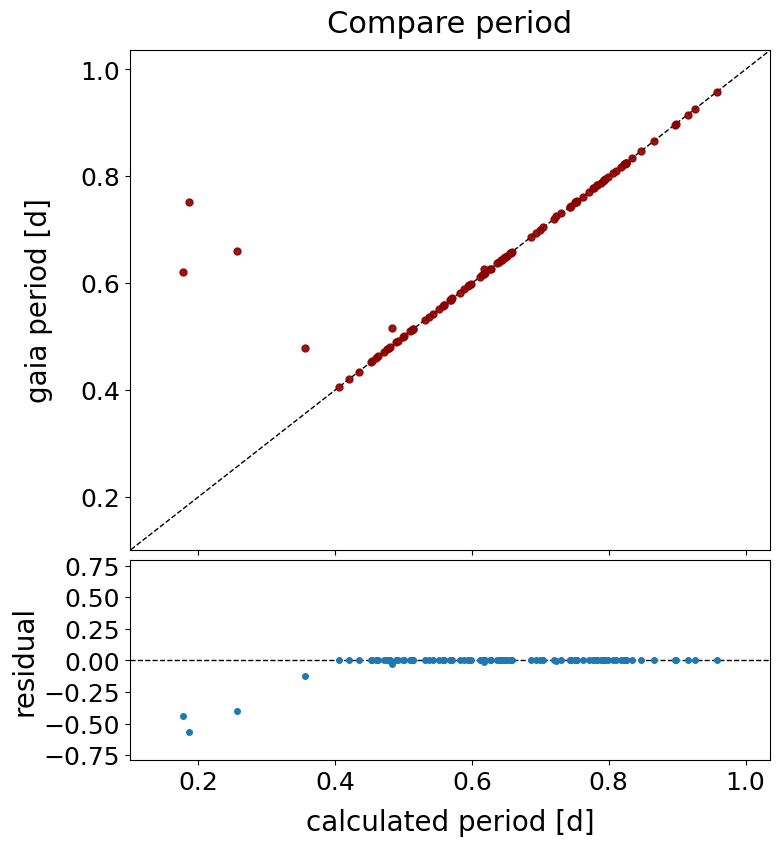

In [17]:
plot_compare_residual(x=[pfs_rrab,'calculated period'],y=[job1['pf'],'gaia period'],quantity='period',units='d')

### Pieriodogram of the sources of which period residuals>0.1

(array([13, 37, 58, 77], dtype=int64),)


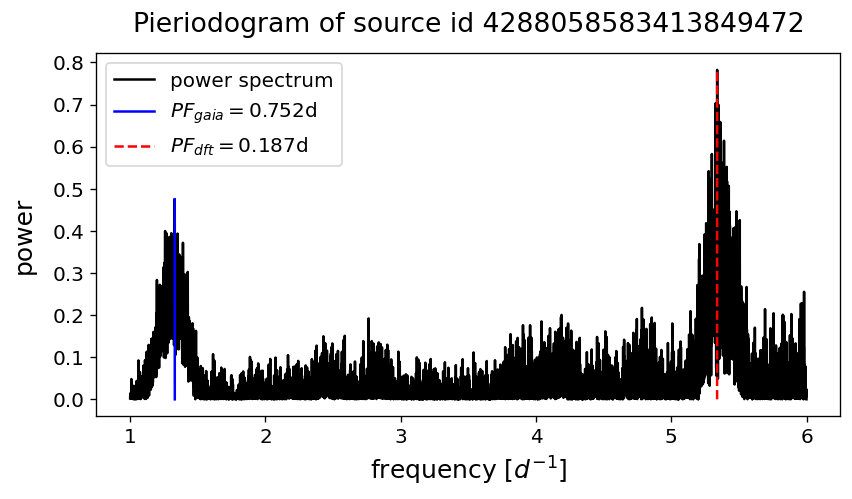

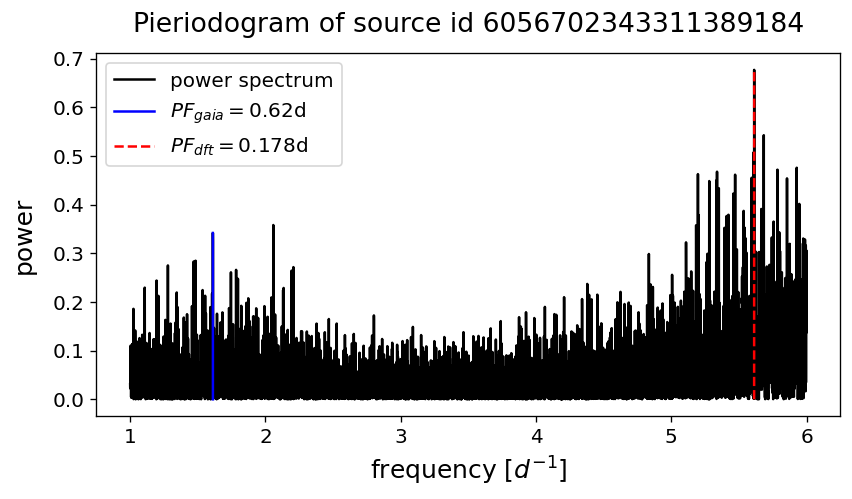

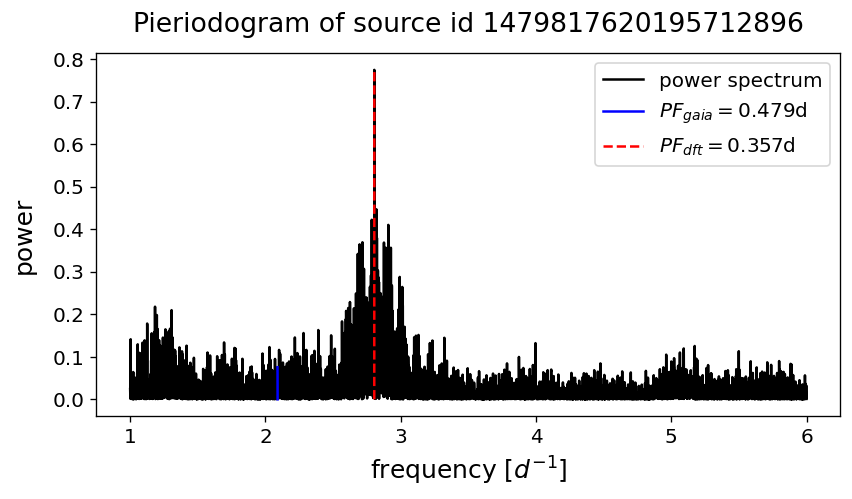

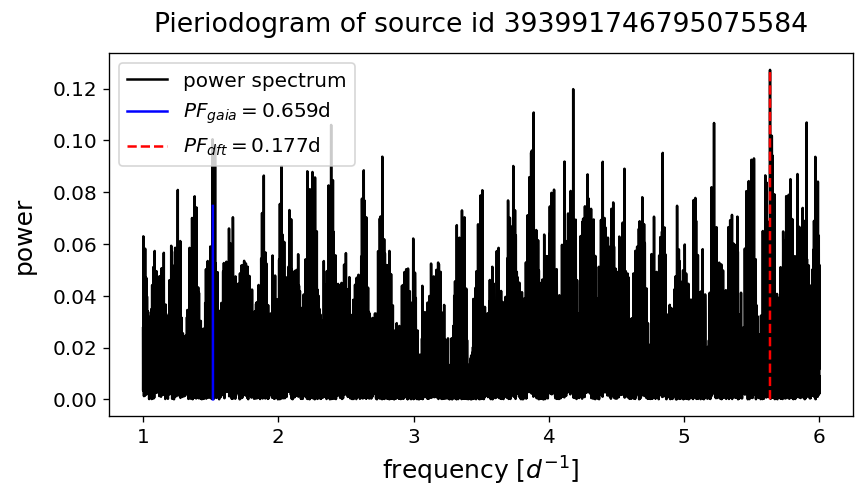

In [18]:
diffs = []
for source in range(len(pfs_rrab)):  
    diff = pfs_rrab[source]-job1['pf'][source]
    diffs.append(diff)
diffs = np.array(diffs)
weird = np.where(abs(diffs)>0.1)
print(weird)
for source in weird[0]:
    table = tables_rrab[source]
    plot_periodogram(table,job1)

### Comment

* **There are 4 estimated periods are very much different from the Gaia reported pf. The wrongly estimated periods are likely to be the sample period of the light curves. **

##  5

* **If y is an array of the n data measured at $t_0$ - $t_n$:**

$$
X=
\left\lgroup
\begin{matrix}
1 & sin(\omega t_0) & sin(2 \omega t_0)&…&sin(k \omega t_0) & cos(\omega t_0) & cos(2 \omega t_0)&…&cos(k \omega t_0) \cr
1 & sin(\omega t_1) & sin(2 \omega t_1)&…&sin(k \omega t_1) & cos(\omega t_1) & cos(2 \omega t_1)&…&cos(k \omega t_1) \cr
&&&&……&&&&\cr
1 & sin(\omega t_n) & sin(2 \omega t_n)&…&sin(k \omega t_n) & cos(\omega t_n) & cos(2 \omega t_n)&…&cos(k \omega t_n) 
\end{matrix}
\right\rgroup
$$

$$
\beta=
\left\lgroup
\begin{matrix}
A_0 \cr a_1 \cr  b_1 \cr  
a_2 \cr  b_2 \cr … \cr  a_k \cr b_k
\end{matrix}
\right\rgroup
$$

## 6

### Plot the phased light curve of Gaia DR2 id = 5813181197970338560

In [19]:
from scipy.optimize import curve_fit as curve_fit

In [20]:
def fourier(t, *a):
    '''
    omega of the fourier series should be define before using this function.
    When *a is input, make sure it is a list with length 2K+1.
    '''
    func = a[0] + a[1] * np.sin(omega * t) + a[2] * np.cos(omega * t)
    for K in range(3, len(a)-1):
        func += a[K] * np.sin(((K+1)/2) * omega * t) + a[K+1] * np.cos(((K+1)/2) * omega * t)
    return func

def fourier_predict(x,y,xpre=None):
    '''
    K, the len of the fourier series coefficients should be define before using this function.
    '''
    if xpre is None:
        xpre = x
    popt, pcov = curve_fit(fourier, x, y, [1.0] * (2*K+1))
    predict = fourier(xpre, *popt)
    return predict

In [21]:
def plot_lightcurve_model(table):
    mag = np.array(table['mag'])
    phase = np.array(table['phase'])
    plotphase = np.arange(0,int(np.max(phase)+1),0.001)
    plotphase = plotphase[np.where(plotphase-np.max(phase)<1e-5)]
    mag_pre = fourier_predict(phase,mag,xpre=plotphase)
    diff = mag-fourier_predict(phase,mag)
    
    axis1min = min(np.min(mag),np.min(mag_pre))-0.1
    axis1max = max(np.max(mag),np.max(mag_pre))+0.1

    fig = plt.figure(figsize=(12,10),dpi=100)
    plt.axes([0.15, 0.3, 0.8, 0.5])
    plt.ylim((axis1max,axis1min))
    plt.xticks(np.arange(int(np.min(phase)),int(np.max(phase)+1),0.1),fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel("G-band magnitude [mag]",fontsize=18,labelpad=20)
    plt.title("Light curve of Gaia DR2 id "+str(sourceid),fontsize=24,pad=15)
    plt.plot(phase, mag,'o',color='r',label="gaia data",markersize=4)
    plt.plot(plotphase,mag_pre,label="curve fit (K="+str(K)+")")
    plt.grid(ls="--")
    plt.legend(fontsize=16)
    plt.axes([0.15, 0.1, 0.8, 0.15])
    plt.xlabel("phase",fontsize=18,labelpad=10)
    plt.ylabel("residual [mag]",fontsize=18,labelpad=14)
    plt.xticks(np.arange(int(np.min(phase)),int(np.max(phase)+1),0.1),fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim((np.max(diff)+0.15,np.min(diff)-0.1))
    plt.plot(phase,diff,'g',marker='.',markersize=8)
    plt.grid(ls="--")
    plt.show()
    

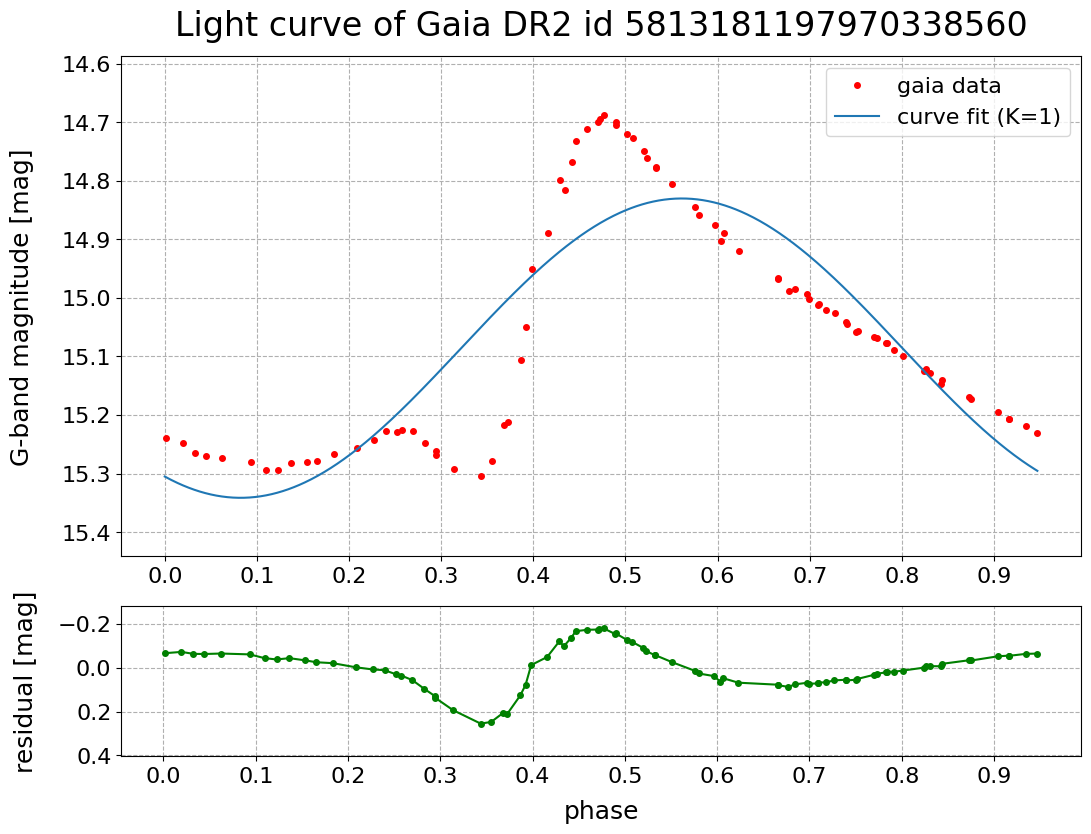

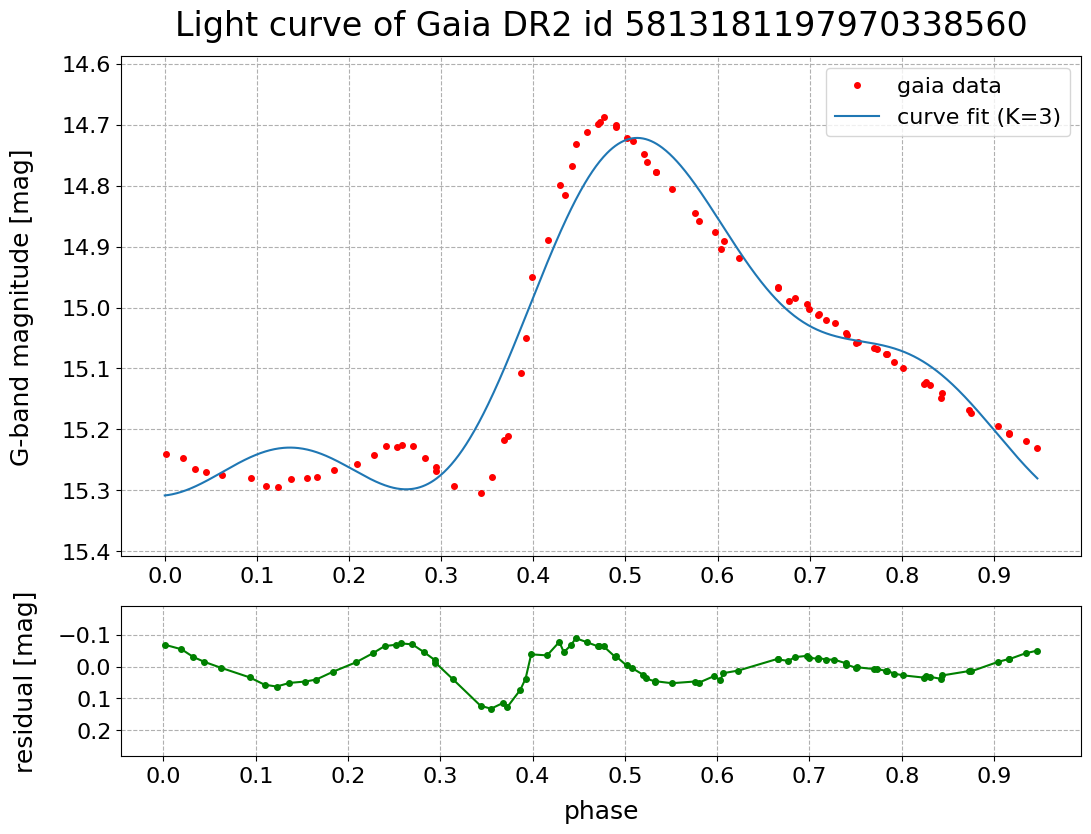

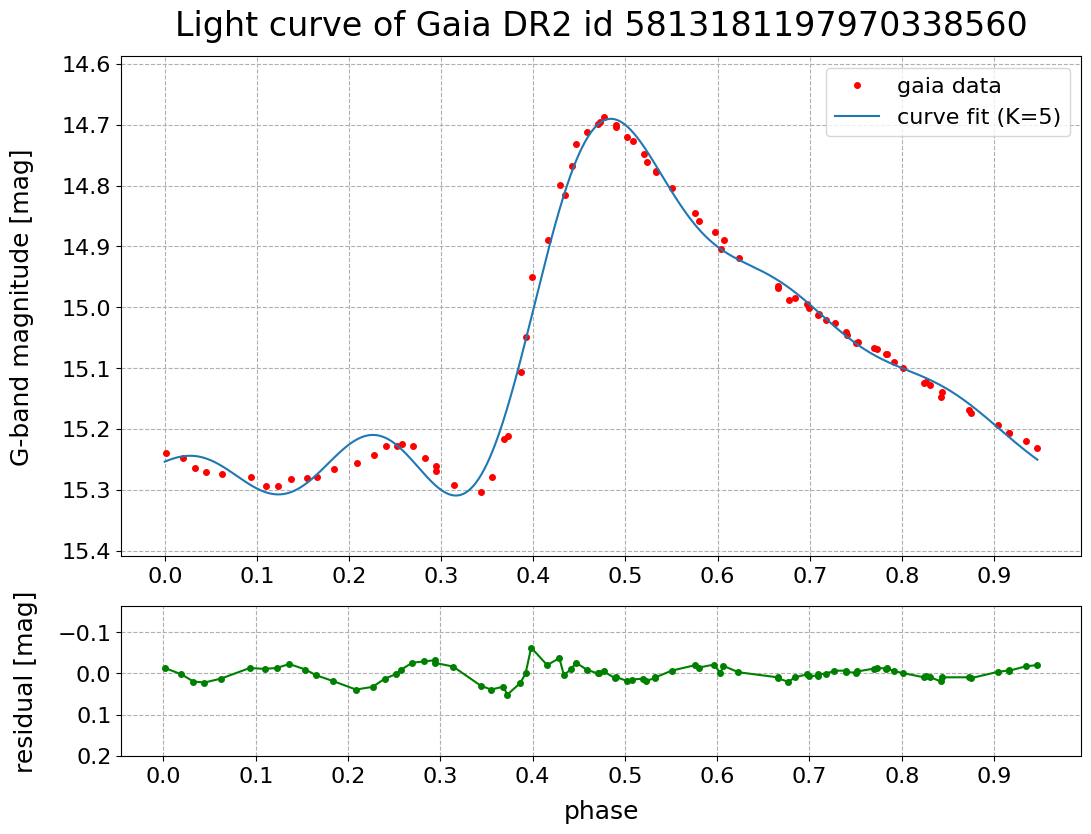

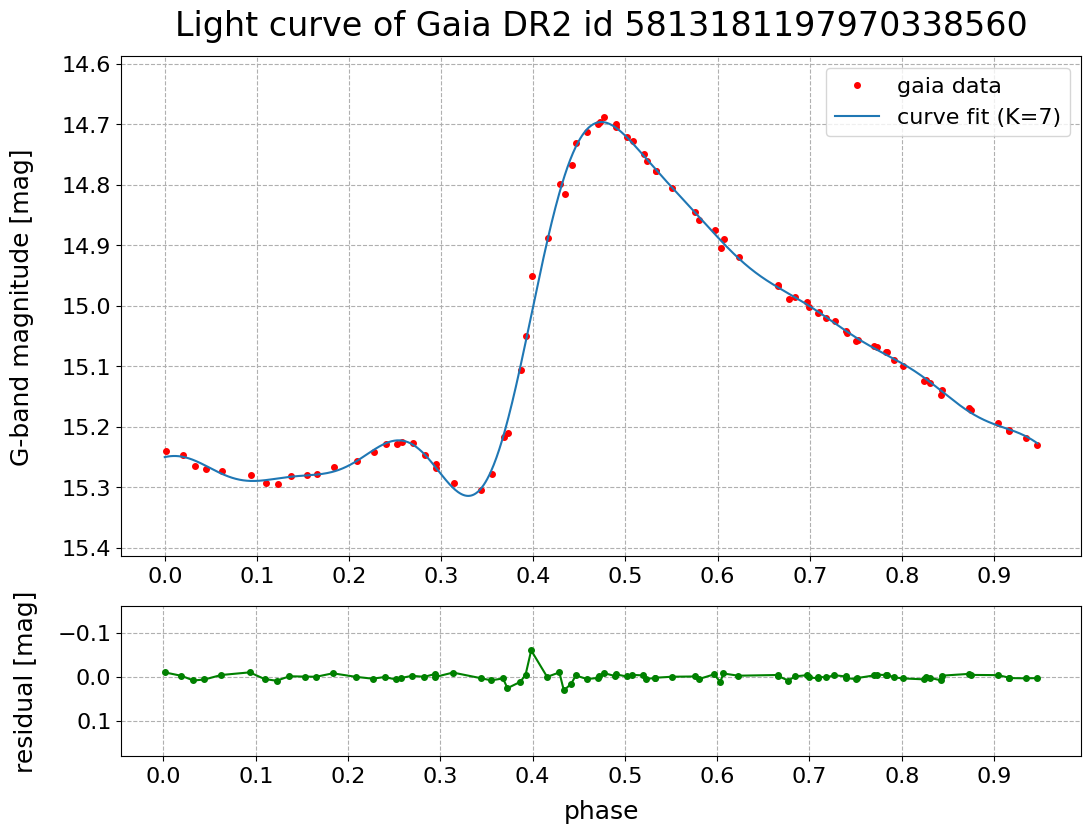

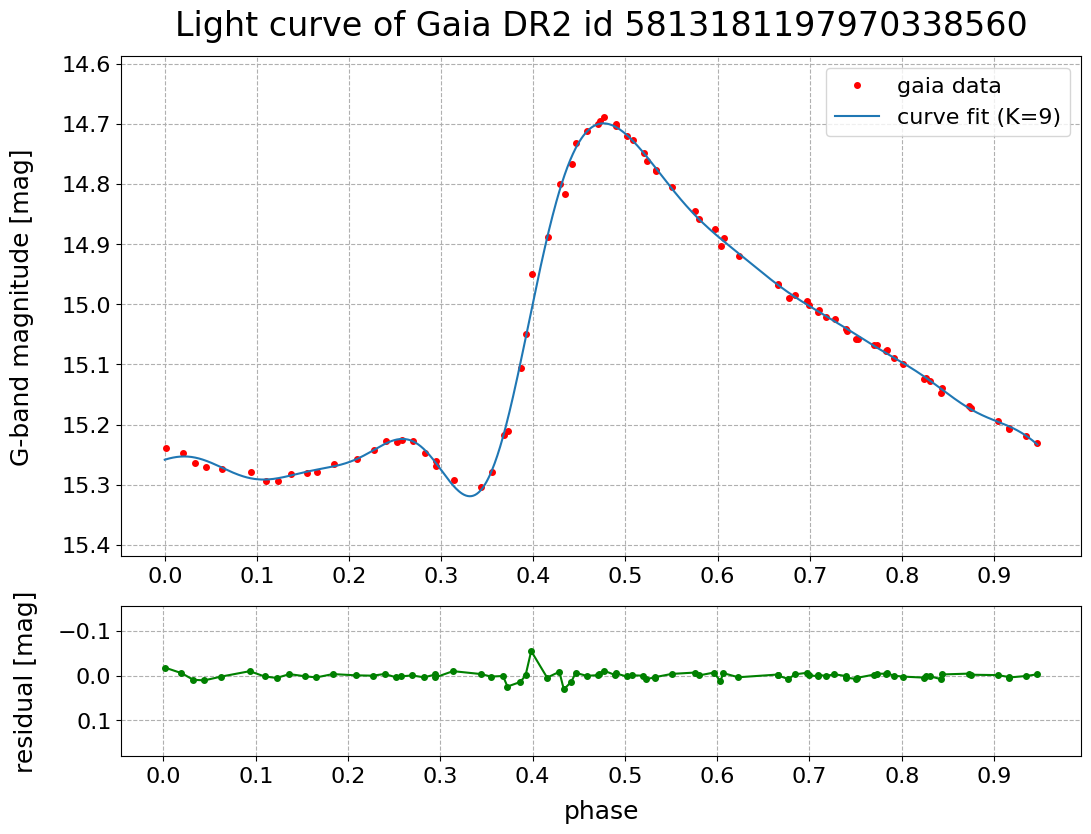

In [22]:
sourceid = 5813181197970338560
table = get_dataframe(job1,source_id=sourceid)
omega= table['omega'][0]

for K in [1,3,5,7,9]:
    plot_lightcurve_model(table)

### Plot for checkpoint 1

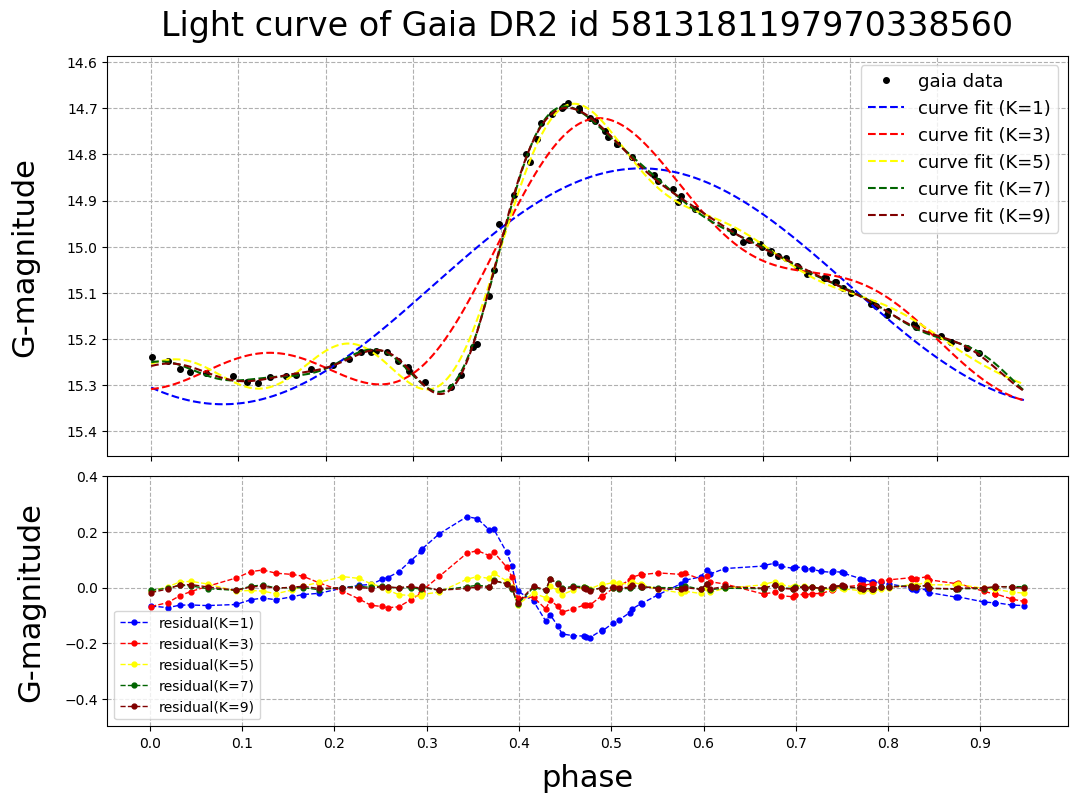

In [23]:
sourceid = 5813181197970338560
table,[mag,phase] = get_dataframe(job1,source_id=sourceid,colname=['mag','phase'])
omega= table['omega'][0]
plotphase = np.arange(0,1,0.001)

fig = plt.figure(figsize=(12,10),dpi=100)
ax1 = plt.axes([0.15, 0.5, 0.8, 0.4])
ax1.set_ylim((np.max(mag)+0.15,np.min(mag)-0.1))
ax1.set_ylabel("G-magnitude",fontsize=22,labelpad=20)
ax1.set_xticks(np.arange(int(np.min(phase)),int(np.max(phase)+1),0.1))
ax1.axes.xaxis.set_ticklabels([])
ax1.set_title("Light curve of Gaia DR2 id "+str(sourceid),fontsize=24,pad=15)
ax1.plot(phase, mag,'o',color='black',markersize=4,label='gaia data')
ax2 = plt.axes([0.15, 0.23, 0.8, 0.25])
ax2.set_xlabel("phase",fontsize=22,labelpad=10)
ax2.set_ylabel("G-magnitude",fontsize=22,labelpad=14)
ax2.set_xticks(np.arange(int(np.min(phase)),int(np.max(phase)+1),0.1))
ax2.set_ylim((-0.5,0.4))
for color,K in [['blue',1],['r',3],['yellow',5,],['darkgreen',7],['maroon',9]]:
    popt, pcov = curve_fit(fourier, phase, mag, [1.0] * (2*K+1))
    ax1.plot(plotphase,fourier(plotphase, *popt),'--',color=color,label="curve fit (K="+str(K)+")")
    ax2.plot(phase,mag-fourier(phase, *popt),linestyle='dashed',marker='.',
             color=color,label="residual(K="+str(K)+")",linewidth=1,markersize=7)

ax1.legend(fontsize=13)
ax2.legend(fontsize=10)
ax1.grid(ls="--")
ax2.grid(ls="--")
plt.savefig("imgs/light_curve.pdf")
plt.show()

### Light curve of the sources of which period residuals>0.1

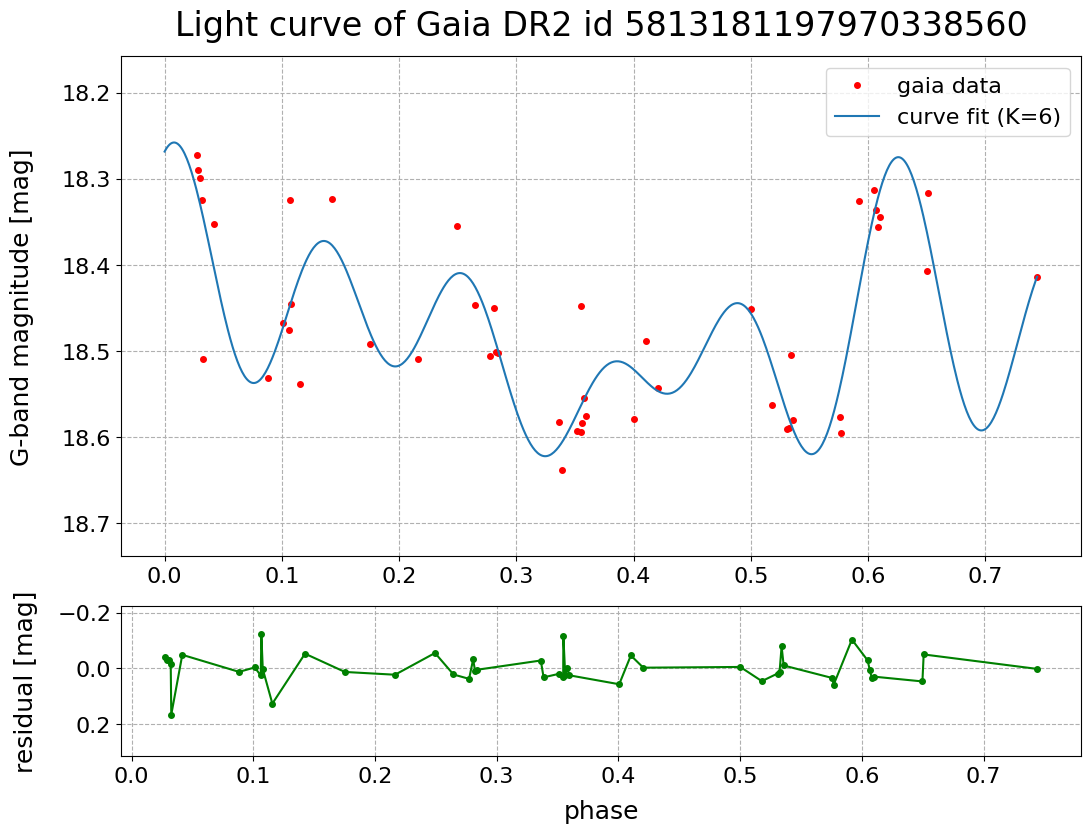

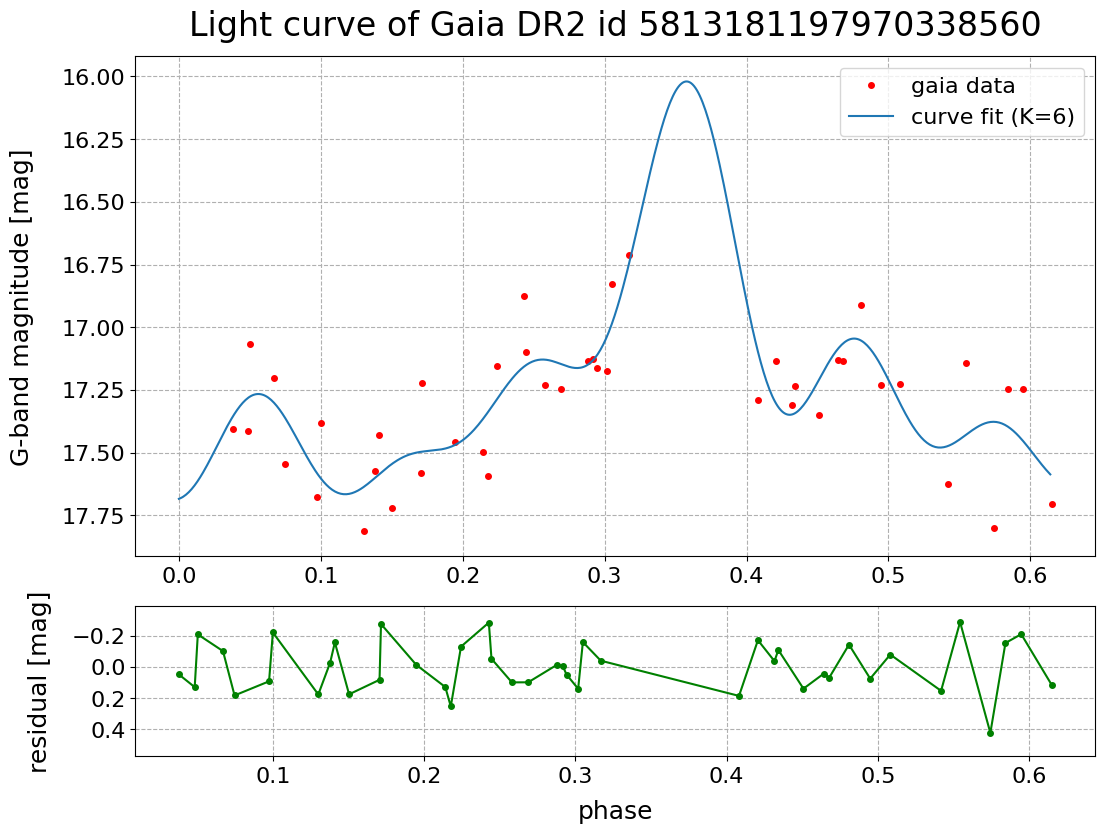

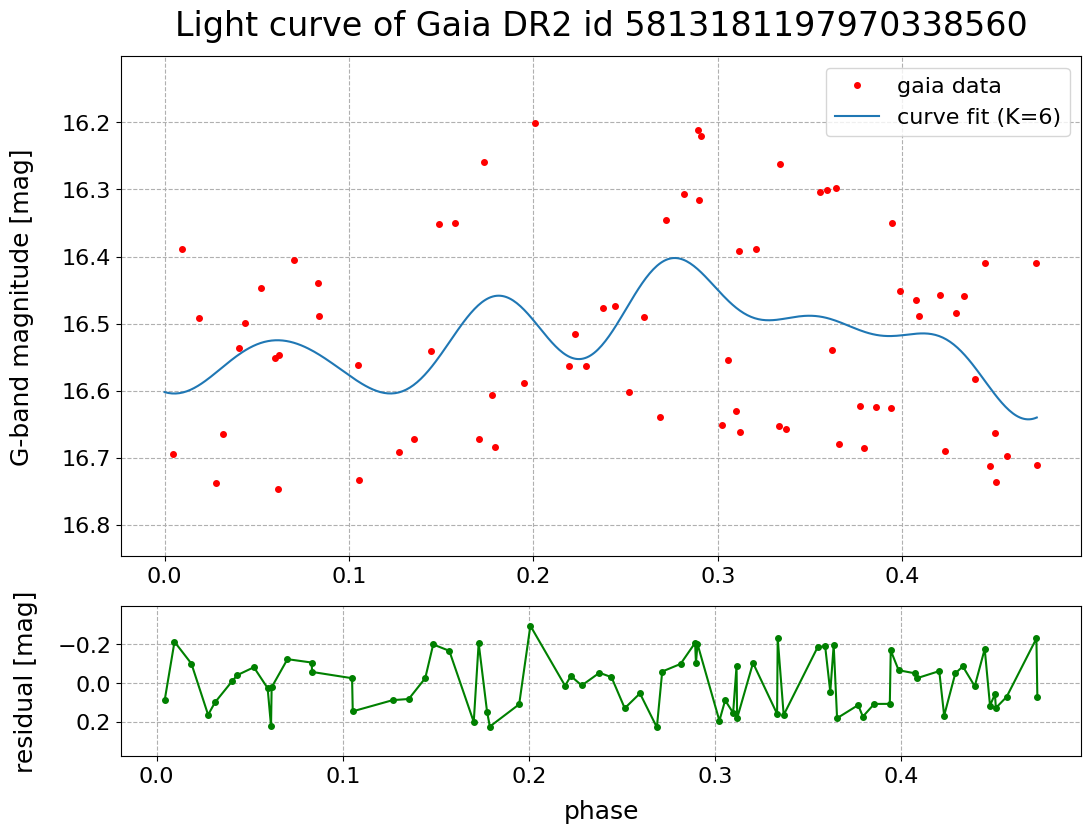

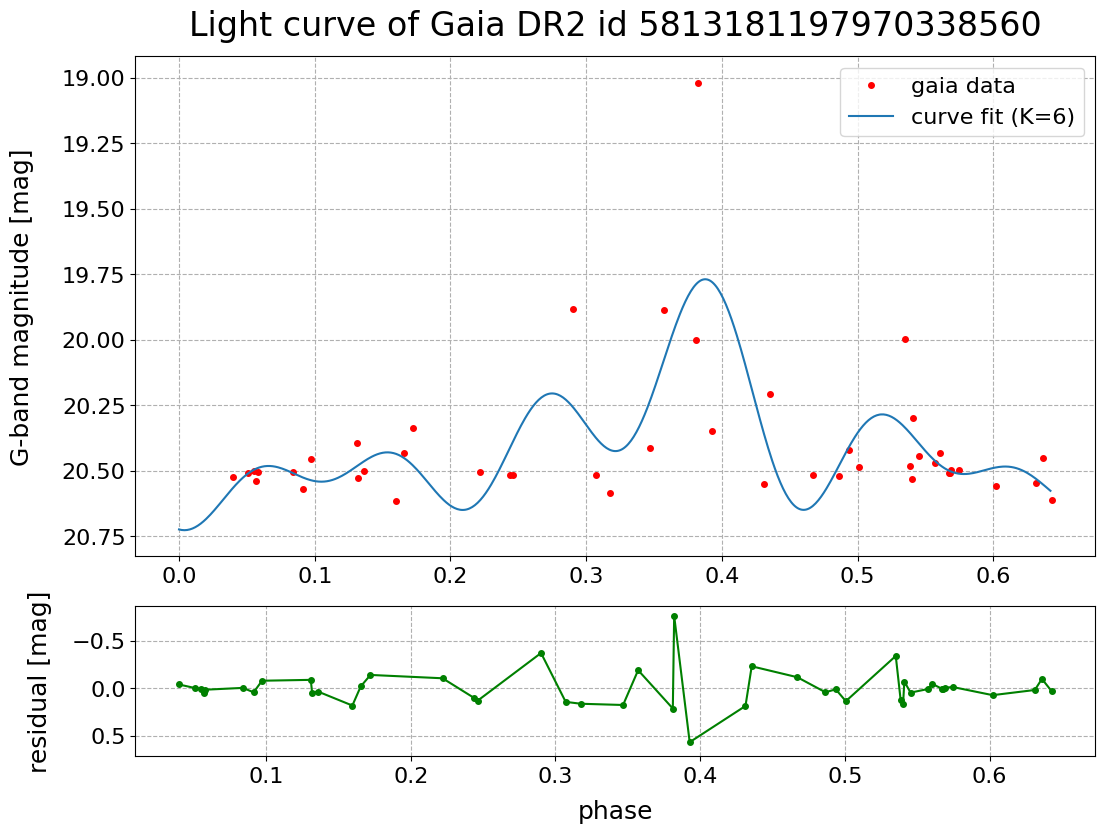

In [23]:
K = 6
for i in weird[0]:
    table = get_dataframe(job1,table=tables_rrab[i])
    omega= table['omega'][0]
    plot_lightcurve_model(table)

## 7

### Use cross-validation to find the optimal K.

In [24]:
from sklearn import model_selection

In [25]:
def chisquare(data,model):
    chi2 = np.sum((data-model)**2/data)
    return chi2

def k_fold_cross_val(table,k,ranseed=4):
    
    def get_train_test_datasets(table,ranseed=ranseed):
        totaltable = table.copy()
        testsize = int(len(table)/k)
        tests = [];trains = []
        for i in range(k):
            if i < k-1:
                test = model_selection.train_test_split(table,test_size=testsize,random_state=ranseed)[1]
                tests.append(test)
                table = table.drop(index=test.index)
                trains.append(totaltable.drop(index=test.index))
            else:
                tests.append(table)
                trains.append(totaltable.drop(index=table.index))
        return [trains,tests]
    trains,tests = get_train_test_datasets(table)
    
    chi_trains = [];chi_tests = []
    for nowid in range(len(tests)):
        train = trains[nowid]
        test = tests[nowid] 
        mag_train = np.array(train['mag']);phase_train = np.array(train['phase'])
        phase_test = np.array(test['phase']);mag_test = np.array(test['mag'])
        
        popt, pcov = curve_fit(fourier, phase_train, mag_train, [1.0] * (2*K+1))
        
        mag_model = fourier(phase_train, *popt)
        mag_predict = fourier(phase_test,*popt)
        
        chi_train = chisquare(data=mag_train,model=mag_model)
        chi_test = chisquare(data=mag_test,model=mag_predict)
        chi_trains.append(chi_train);chi_tests.append(chi_test)
        
    return np.mean(chi_trains),np.mean(chi_tests)


For the 1 th dataset, the best K are 6 for test data 25 for training data. 
For the 2 th dataset, the best K are 6 for test data 25 for training data. 
For the 3 th dataset, the best K are 6 for test data 25 for training data. 


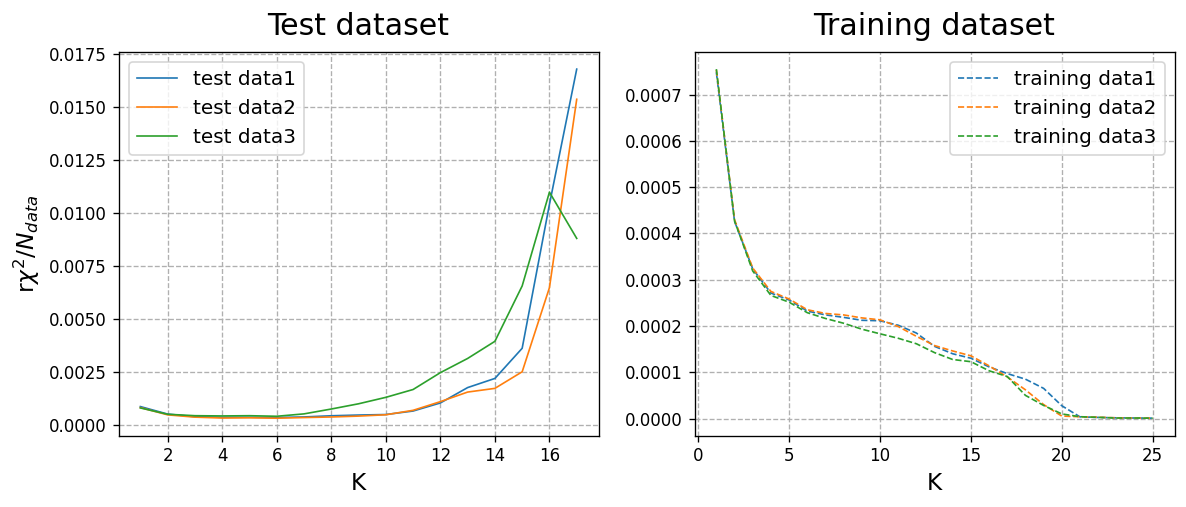

In [27]:
sourceid = 5813181197970338560
table = get_dataframe(job1,sourceid)

fig = plt.figure(figsize=(10,4),dpi=120)
ax1 = plt.axes([0.1, 0.1, 0.4, 0.8])
ax2 = plt.axes([0.58, 0.1, 0.4, 0.8])
for i in range(3):
    ranseed = random.randint(0,99)
    chi_trains = [];chi_tests = []
    for K in range(1,26):
        chi_train,chi_test = k_fold_cross_val(table,k=5,ranseed=ranseed)
        chi_trains.append(chi_train),chi_tests.append(chi_test)

    chi_tests = np.array(chi_tests)
    chi_trains = np.array(chi_trains)
    ntest = len(table)/5
    ntrain = len(table)-len(table)/5
    chi_tests = chi_tests/ntest
    chi_trains = chi_trains/ntrain
    print("For the",i+1,"th dataset, the best K are",np.argmin(chi_tests)+1,
          "for test data",np.argmin(chi_trains)+1,"for training data. ")
    # make a slice here to avoid showing very large chi^2 due to overfitting
    ax1.plot(np.arange(1,18,1),chi_tests[:17],label="test data"+str(i+1),linewidth=1)
    ax1.set_ylabel('r$\chi^2/N_{data}$',fontsize=14)
    ax1.set_xlabel('K',fontsize=14)
    ax1.grid(ls='--')
    ax1.set_title("Test dataset",fontsize=18,pad=10)
    ax1.legend(fontsize=12)
    
    ax2.plot(np.arange(1,26,1),chi_trains,'--',label="training data"+str(i+1),linewidth=1)
    ax2.set_xlabel('K',fontsize=14)
    ax2.grid(ls='--')
    ax2.set_title("Training dataset",fontsize=18,pad=10)
    ax2.legend(fontsize=12)
plt.show()

### Discuss what an appropriate value of K for this data set might be.

* ** The best K is $K=6$.**
* ** As shown in the figure above, when $K>6$, $\chi^2$ begins to increase due to overfitting.**

## 8

### Predict the expected magnitude of the star at t = 2329.0

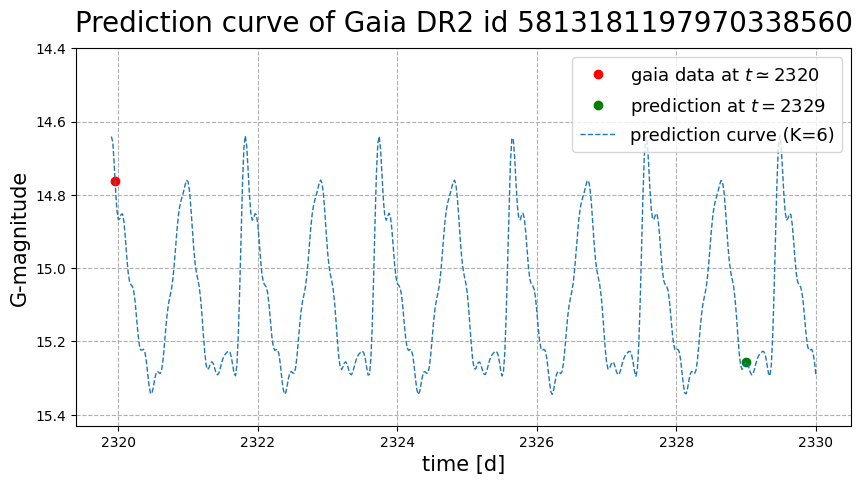

In [28]:
sourceid = 5813181197970338560
table,[mag,t] = get_dataframe(job1,source_id=sourceid,colname=['mag','time'])
omega= table['omega'][0]

K=6
t_pre = np.linspace(2319,2330,551)
mag_pre = fourier_predict(t, mag,t_pre)
fig = plt.figure(figsize=(10,5),dpi=100)
ax1 = fig.add_subplot(1,1,1)
ax1.set_ylim((15.43,14.4))
ax1.set_ylabel("G-magnitude",fontsize=15)
ax1.set_xlabel("time [d]",fontsize=15)
ax1.set_title("Prediction curve of Gaia DR2 id "+str(sourceid),fontsize=20,pad=12)
ax1.plot(t[np.where(t-2319.9>0)][0], mag[np.where(t-2319.9>0)][0],'o',color='r',label='gaia data at $t\simeq 2320$')
ax1.plot(t_pre[int(np.where(t_pre==2329)[0])], mag_pre[int(np.where(t_pre==2329)[0])],
         'o',color='g',label='prediction at $t=2329$')
ax1.plot(t_pre[45:],mag_pre[45:],'--',label="prediction curve (K="+str(K)+")",linewidth=1)

ax1.legend(fontsize=13)
ax1.grid(ls="--")
plt.savefig("imgs/predict_curve.pdf")
plt.show()

## 9

In [29]:
K = 6

mag_means_model_rrab = []
for table in tables_rrab:
    table,[mag,t,flux,phase] = get_dataframe(job=job1,table=table,colname=['mag','time','flux','phase'])
    pf = table['pf'][0]
    omega = table['omega'][0]

    t_pre = np.linspace(0,pf,1001)
    flux_model = fourier_predict(phase,flux,t_pre)

    flux_mean_model = flux_model.mean()
    mag_mean = mag[0]+2.5*np.log10(flux[0]/flux_mean_model)
    mag_means_model_rrab.append(mag_mean)


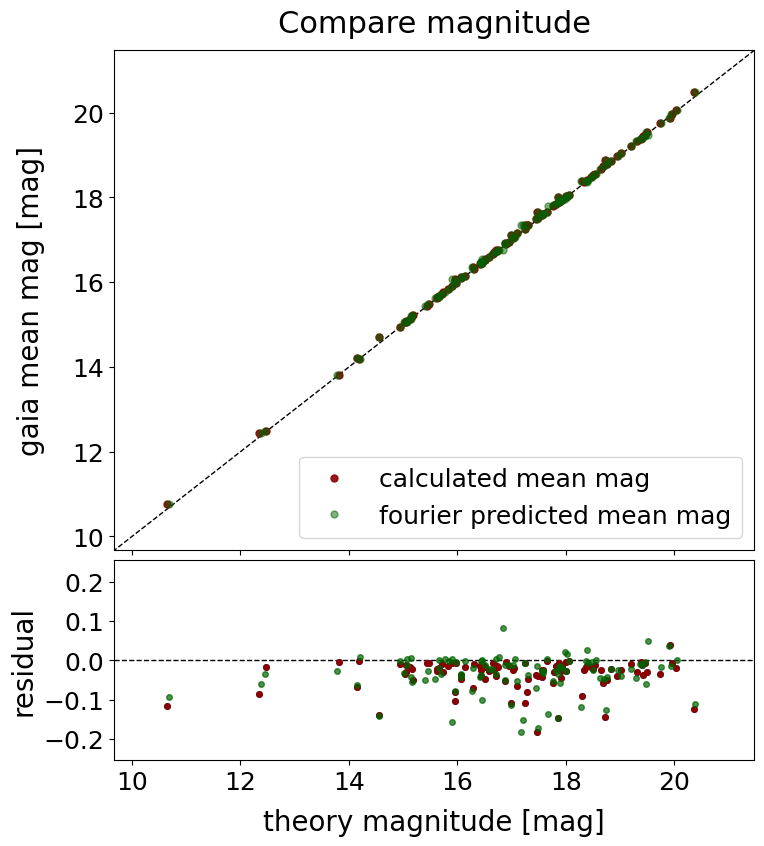

In [30]:
plot_compare_residual(x=[mag_means_rrab,'calculated mean mag',mag_means_model_rrab,'fourier predicted mean mag'],
                      y=[job1['phot_g_mean_mag'],'gaia mean mag'],
                      quantity='magnitude',units='mag')

### Comment :
* **Compared with calculated mean magnitude in part 3, it appears that the model fitting mean magnitude is more scattered than calculated ones. May due to the fitting model is not accurate enough so that when average flux over one pulsation period, the mean flux is not accurate. **

## 10

In [31]:
query_2 = '''SELECT TOP 3 *
             FROM gaiadr2.vari_rrlyrae 
             JOIN gaiadr2.gaia_source as gaia USING (source_id)
             WHERE vari_rrlyrae.best_classification = 'RRc'
             AND vari_rrlyrae.int_average_G < 15
             AND vari_rrlyrae.num_clean_epochs_g > 80'''

In [32]:
job2 = get_gaia_query(query_2)

The light curve of the 1 RRc source has been added.
The light curve of the 2 RRc source has been added.
The light curve of the 3 RRc source has been added.


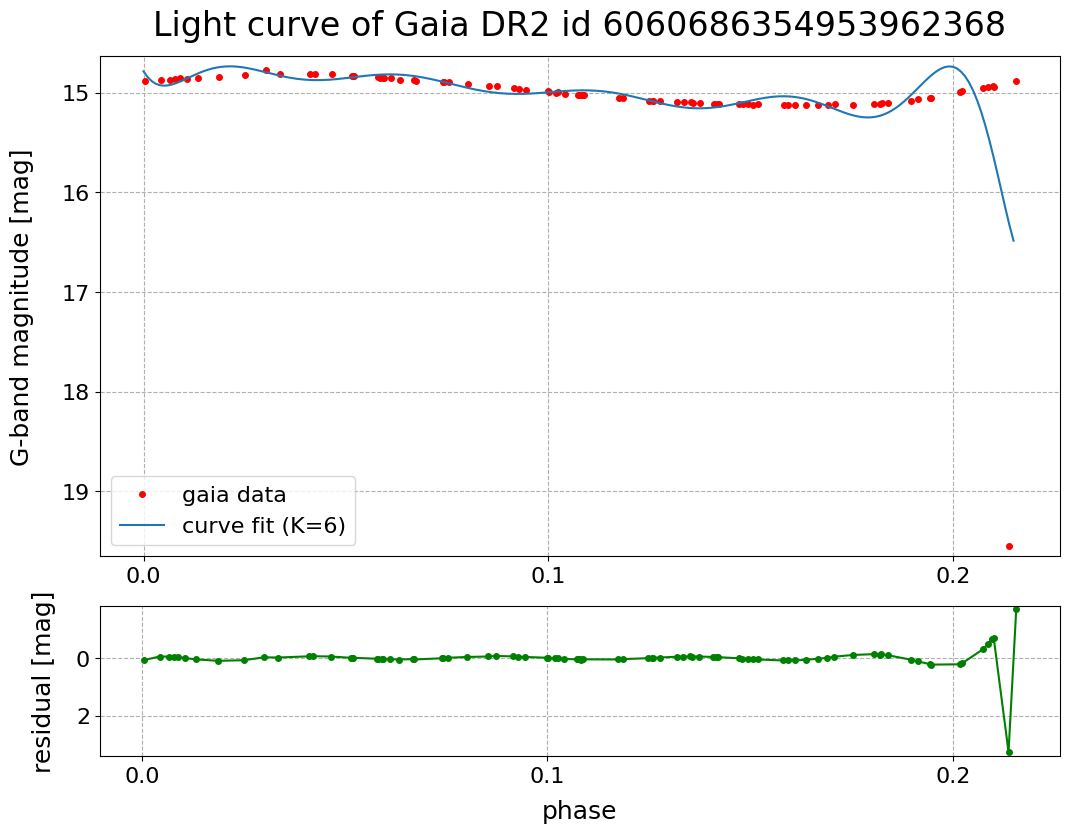

In [33]:
tables_rrc = []
for source in range(len(job2)):
    url = job2["epoch_photometry_url"][source]
    table = get_astro_table(url)
    table = table[np.where(table['band']=="G")]
    tables_rrc.append(table)
    print("The light curve of the",source+1,"RRc source has been added.")
    
pfs_rrc = []
for source in range(len(tables_rrc)):  
    table = tables_rrc[source]

    t,flux,flux_er,mag = get_col(table,['time','flux','flux_error','mag'])
    error = 2.5*np.log10(flux_er)

    freq, power = LombScargle(t, mag,dy=error).autopower(minimum_frequency=fmin,maximum_frequency=fmax)
    pf = 1/freq[np.argmax(power)]
    pfs_rrc.append(pf)

# Show the outlier and delete this data point.
sourceid = 6060686354953962368
table = get_dataframe(job2,source_id=sourceid)
plot_lightcurve_model(table)

index = table.loc[(table['mag']>17)].index[0]

table = table.drop([index])
table = Table.Table.from_pandas(table)

# Add the new table.
tables_rrc[1] = table

pfs_rrc = []
for source in range(len(tables_rrc)):  
    table = tables_rrc[source]

    t,flux,flux_er,mag = get_col(table,['time','flux','flux_error','mag'])
    error = 2.5*np.log10(flux_er)

    freq, power = LombScargle(t, mag,dy=error).autopower(minimum_frequency=fmin,maximum_frequency=fmax)
    pf = 1/freq[np.argmax(power)]
    pfs_rrc.append(pf)

* **As shown above, for Gaia DR2 id 6060686354953962368, there is an outlier. This outlier may due to some transient phenomena. But it influences the accuracy of model fitting, and should be delete.**

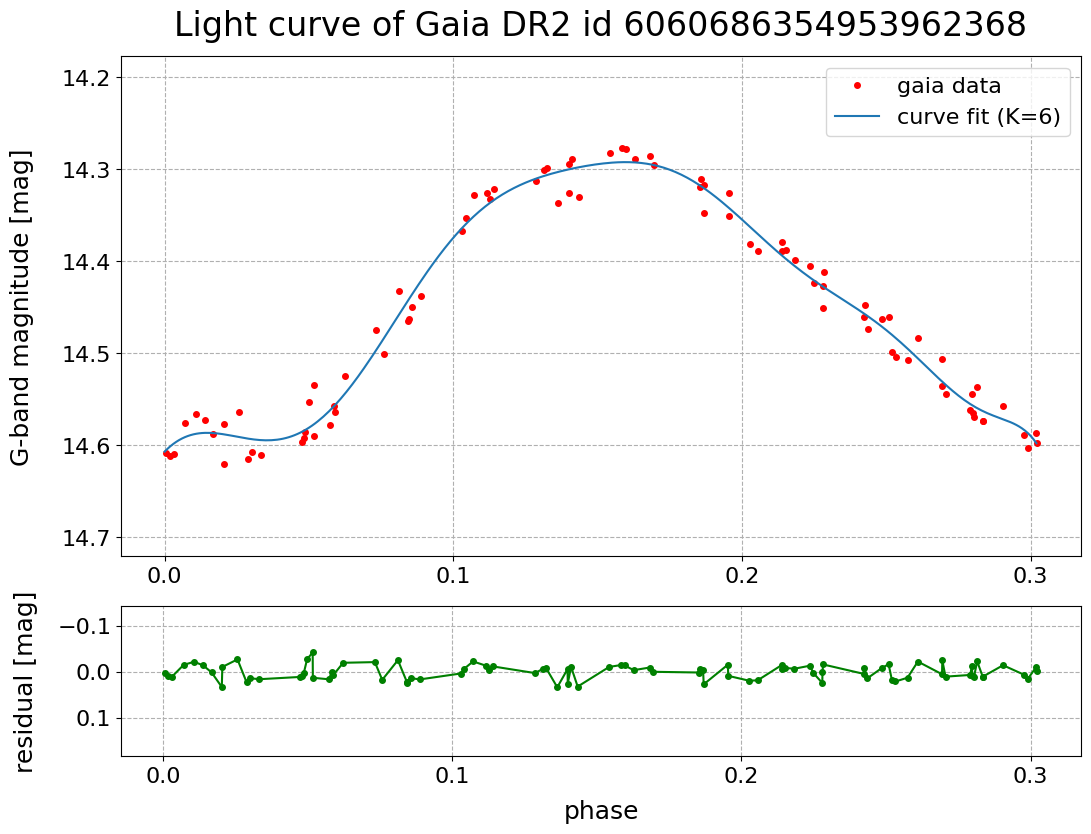

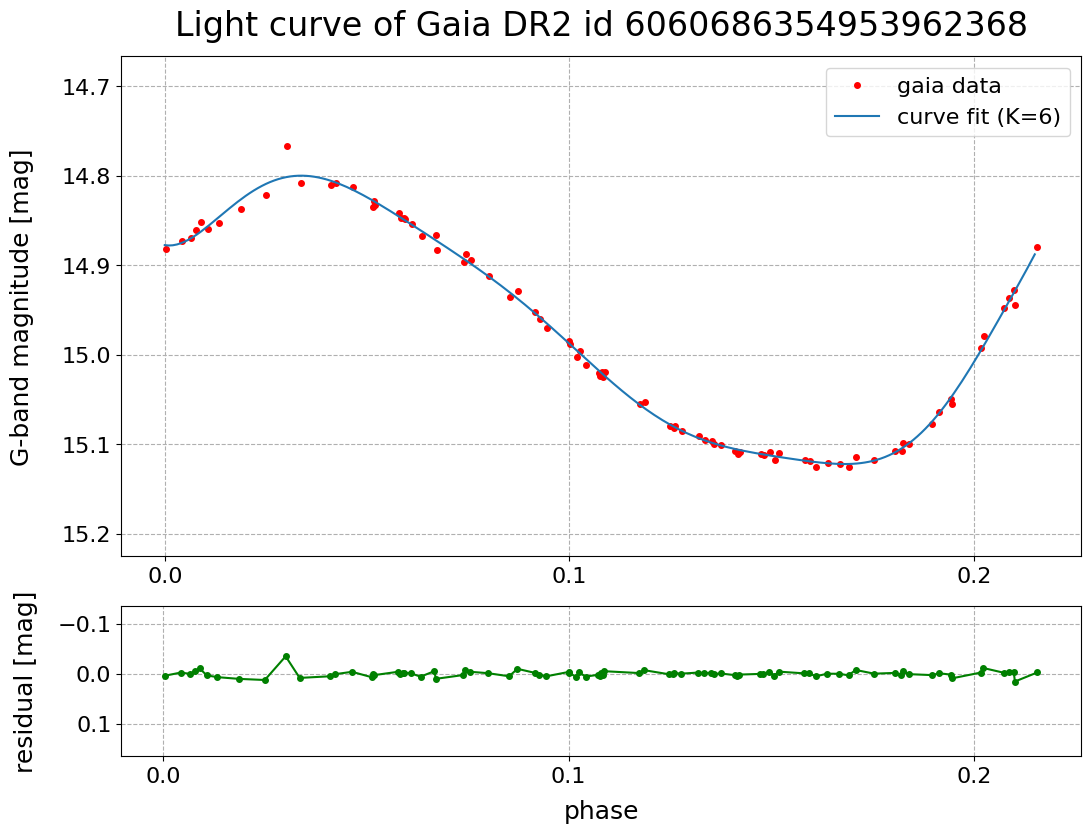

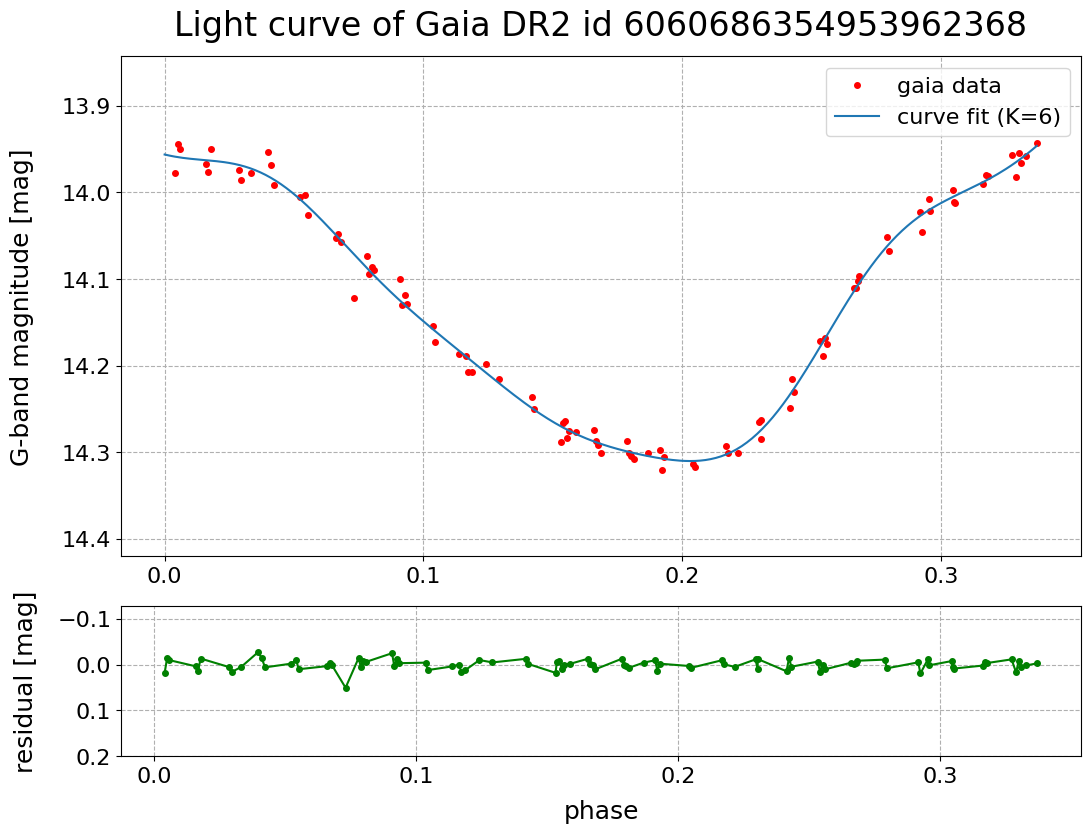

In [34]:
K = 6
for table in tables_rrc:
    table = get_dataframe(job2, table=table)

    plot_lightcurve_model(table)

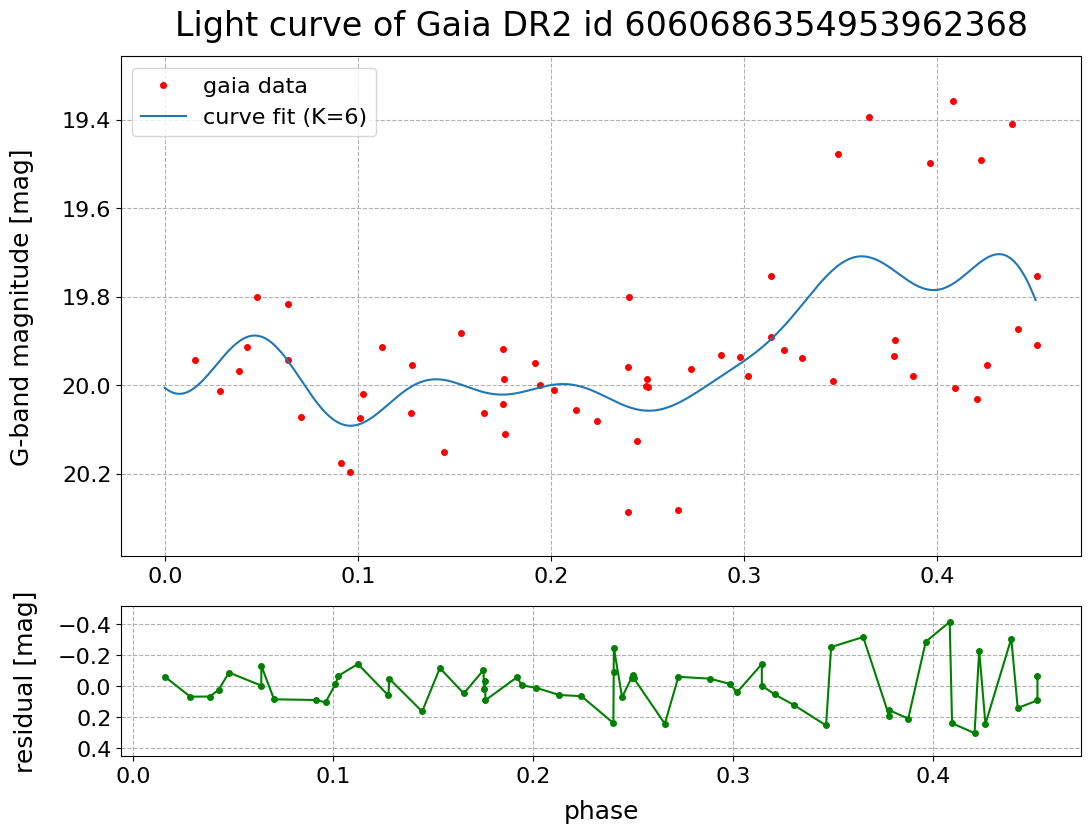

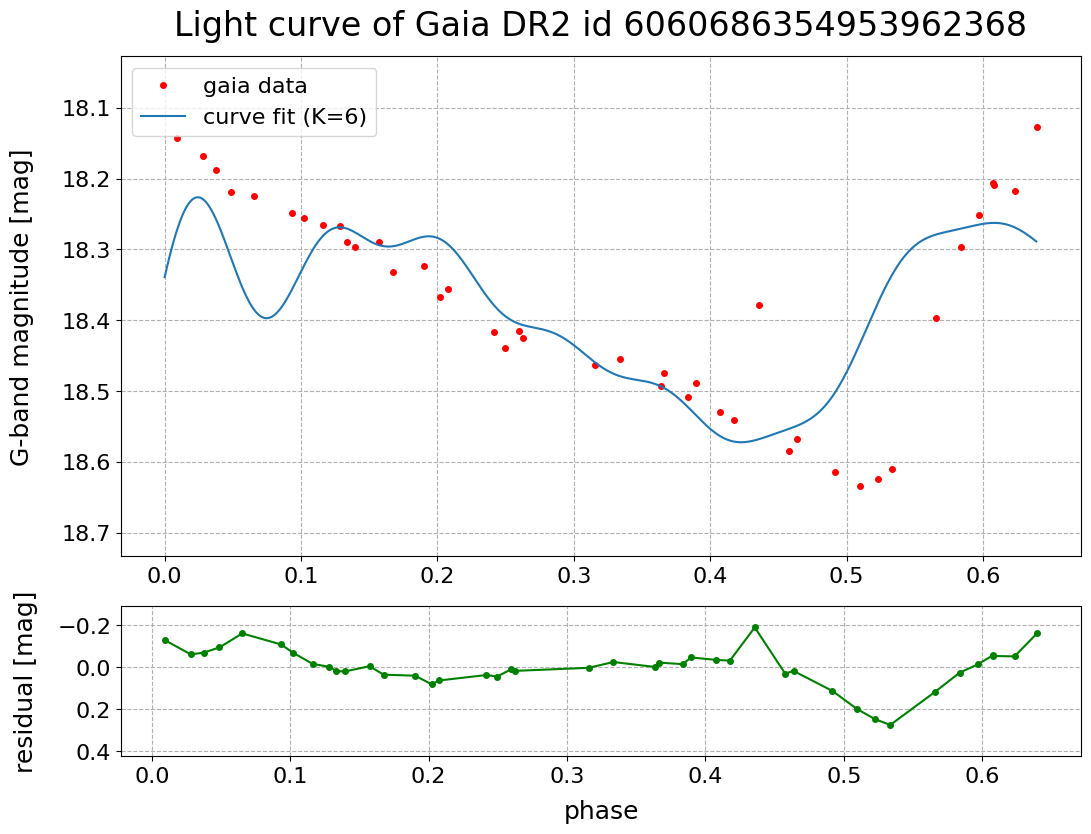

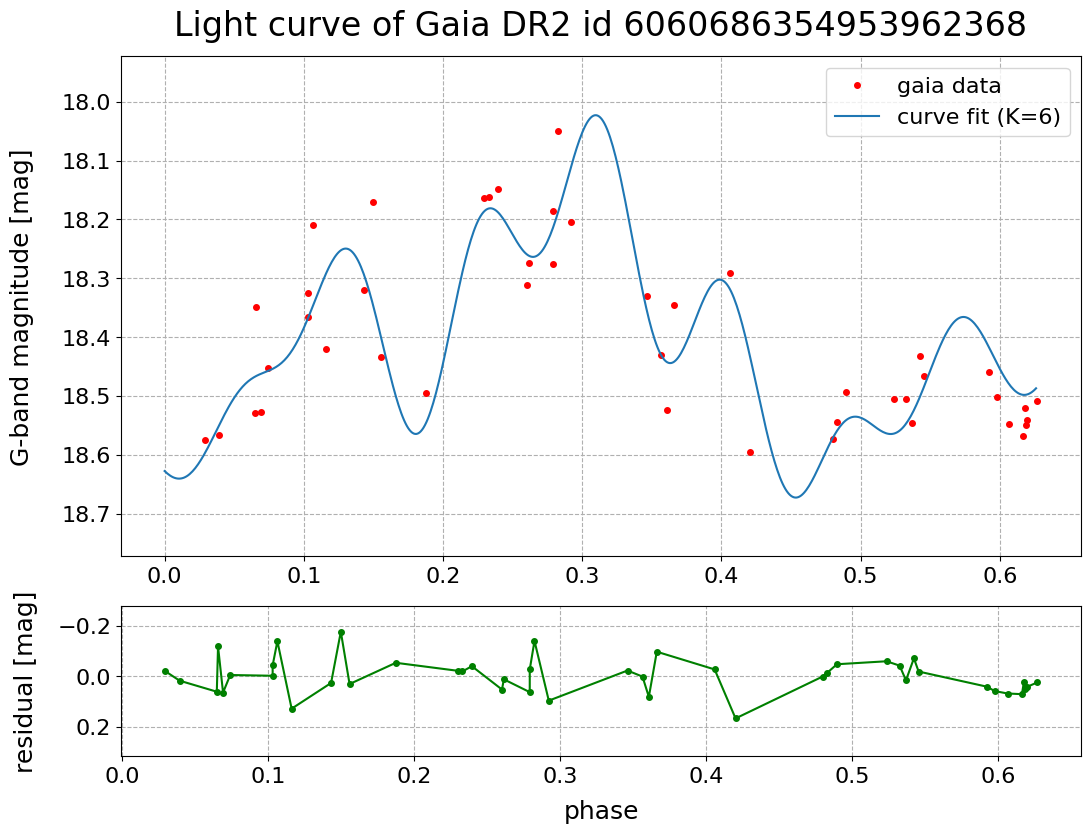

In [35]:
K = 6
for table in tables_rrab[:3]:
    table = get_dataframe(job1, table=table)

    plot_lightcurve_model(table)

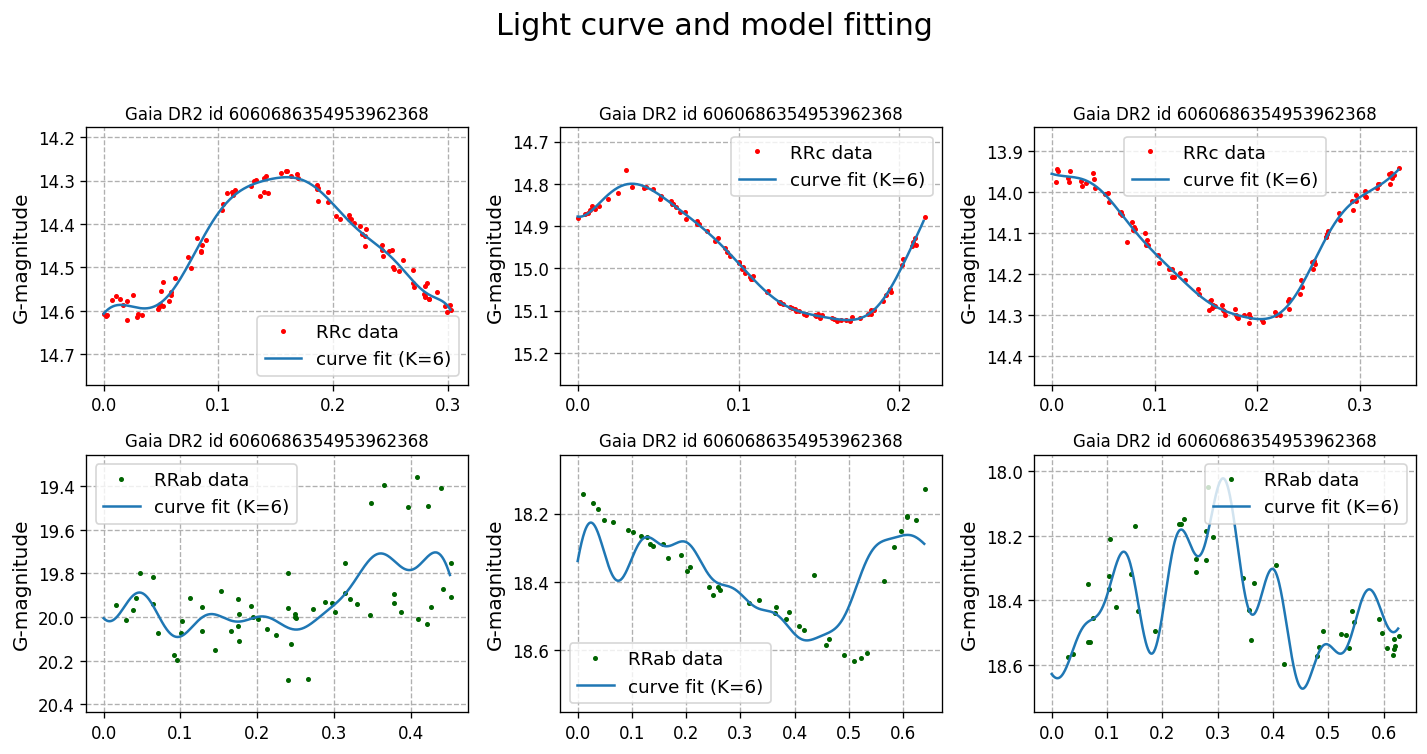

In [36]:
K = 6
tableplot = []
for table in tables_rrc:
    tableplot.append(table)
for table in tables_rrab[:3]:
    tableplot.append(table)

fig, axes = plt.subplots(2,3,figsize=(12,6),dpi=120)

for i in range(len(tableplot)):
    if i<3:
        table = get_dataframe(job=job2,table=tableplot[i])
    else:
        table = get_dataframe(job=job1,table=tableplot[i])

    mag = np.array(table['mag'])
    phase = np.array(table['phase'])
    plotphase = np.arange(0,int(np.max(phase)+1),0.001)
    plotphase = plotphase[np.where(plotphase-np.max(phase)<1e-5)]
    mag_pre = fourier_predict(phase,mag,xpre=plotphase)
    diff = mag-fourier_predict(phase,mag)
    
    ax = axes[i//3][i%3]
    ax.set_ylim((np.max(mag)+0.15,np.min(mag)-0.1))
    ax.set_xticks(np.arange(int(np.min(phase)),int(np.max(phase)+1),0.1))
    ax.set_ylabel("G-magnitude",fontsize=12)
    ax.set_title("Gaia DR2 id "+str(sourceid),fontsize=10,pad=5)
    if i<3:
        ax.plot(phase, mag,'o',color='r',label="RRc data",markersize=2)
    else:
        ax.plot(phase, mag,'o',color='darkgreen',label="RRab data",markersize=2)
    ax.plot(plotphase,mag_pre,label="curve fit (K="+str(K)+")")
    ax.grid(ls="--")
    ax.legend(fontsize=11)

fig.suptitle('Light curve and model fitting',y=1.04,fontsize=18)
fig.tight_layout()
plt.show()

### Comment on the difference in light curve shape between the two classes.

* **RRc data can be well fitted by the fourier model. On the contray, RRab data seems to scatter a lot**

## 11

### ** Are the 6 light curves you plotted well-described by a single period, or is there evidence of intrinsic scatter?**

* **For RRc stars they are well-described, but for RRab stars, there is evidence of intrinsic scatter. **

## 12

### Why using Gaia distances to estimate the absolute magnitude will only work if there isn’t a lot of dust.
    
* ** Because if there is a lot of dust between us and the RR Lyraes, it would cause extinction and redding. Therefore the flux measured is incorrect and so is the magnitude. It would lead to a wrongly estimated absolute magnitude. **


### Write an ADQL query to select RR Lyrae stars that
** (a) have accurately measured distances, with parallax errors of less than 20%, **

** (b) are above or below the disk, with jbj > 30 degrees, where b is Galactic latitude, **

** (c) are relatively nearby, with distances less than 4 kpc.**

In [37]:
query_3 ='''SELECT *
            FROM gaiadr2.vari_rrlyrae as rr
            INNER JOIN gaiaedr3.dr2_neighbourhood as gaiadr23 on gaiadr23.dr2_source_id = rr.source_id
            JOIN gaiaedr3.gaia_source as gaia3 on gaia3.source_id = gaiadr23.dr3_source_id
            WHERE abs(1/gaia3.parallax_over_error) < 0.2
            AND abs(gaia3.b) > 30
            AND abs(gaia3.parallax) > 0.25
            AND rr.pf IS NOT NULL'''

In [38]:
job3 = get_gaia_query(query_3)
print(len(job3),'objects are founded.')
print(len(np.where(job3['dr2_source_id']!=job3['dr3_source_id'])[0]),'sources changed their IDs.')

583 objects are founded.
78 sources changed their IDs.


### ** Explain why IDs might change.**

** This is because of the developments in the clustering algorithm, or for the bright sources
around magnitude G = 10 because the double-detection threshold was recalibrated. Moreover, an evolution may also occur for
very bright sources where the large number of spurious detections and spurious sources may create multiple cluster-source
links that can lead to new source identifiers for these bright
sources.**


## 13

### Write another ADQL query that gets these distance estimates and uncertainties

In [39]:
query_3a = '''SELECT ext.source_id,ext.r_med_geo,ext.r_hi_geo,ext.r_lo_geo
             FROM external.gaiaedr3_distance as ext
             JOIN gaiaedr3.gaia_source as gaia3 on gaia3.source_id = ext.source_id
             INNER JOIN gaiaedr3.dr2_neighbourhood as gaiadr23 on gaiadr23.dr3_source_id = gaia3.source_id
             JOIN gaiadr2.vari_rrlyrae as rr on gaiadr23.dr2_source_id = rr.source_id
             WHERE abs(1/gaia3.parallax_over_error) < 0.2
             AND abs(gaia3.b) > 30
             AND abs(gaia3.parallax) > 0.25
             AND rr.pf IS NOT NULL'''

In [40]:
job3a = get_gaia_query(query_3a)

In [41]:
job3 = get_gaia_query(query_3)
job3.add_columns([job3a['r_med_geo'],job3a['r_hi_geo'],job3a['r_lo_geo']])

### ** Explain how these are calculated. **

### Besides the prior, what’s the important difference between these distance and the ones inverting the parallaxes?

## 14

### Plot the distribution of targets you obtained in Galactic coordinates.

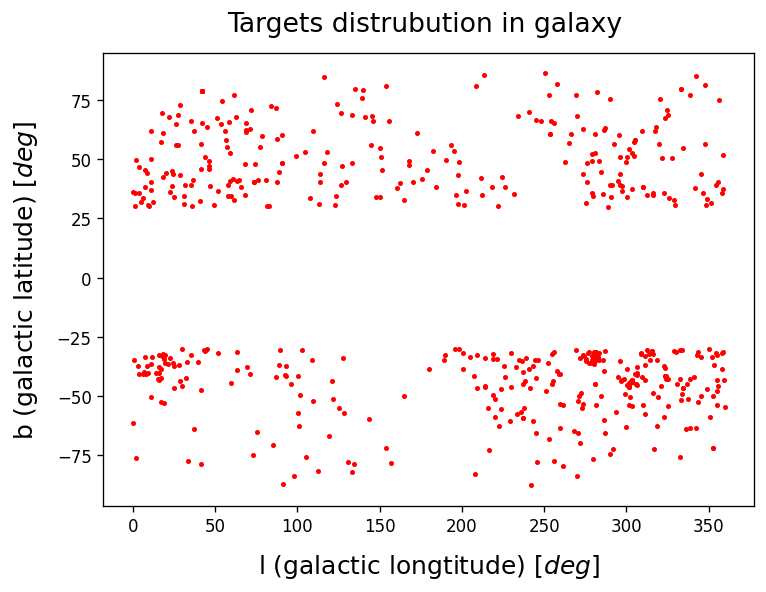

In [42]:
def plot_galaxy_structure(job):

    fig = plt.figure(figsize=(7,5),dpi=120)
    plt.plot(job['l'], job['b'],'r.',markersize=4)
    plt.ylabel(r"b (galactic latitude) $[deg]$",fontsize=15,labelpad=10)
    plt.xlabel(r"l (galactic longtitude) $[deg]$",fontsize=15,labelpad=10)
    plt.title("Targets distrubution in galaxy ",fontsize=16,pad=13)
    plt.show()
    
plot_galaxy_structure(job3)

### Compare the distance estimate from the Bailer-Jones catalog to the naive distance estimate from $d = 1/\omega$.

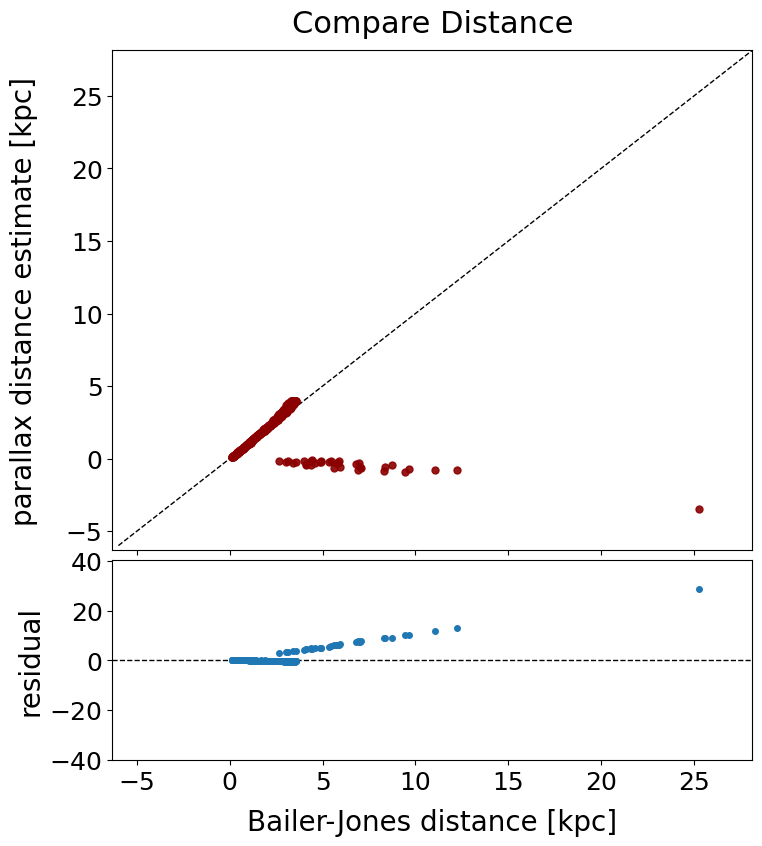

In [43]:
plot_compare_residual(x=[job3['r_med_geo']/1e3,'Bailer-Jones distance'],
                      y=[1/job3['parallax'],'parallax distance estimate'],
                      quantity='Distance',units='kpc')

### Plot the DR2 vs DR3 parallaxes for this sample, showing uncertainties as error bars.

In [44]:
query_3b = '''SELECT gaia2.source_id,gaia2.parallax AS dr2_parallax,gaia2.parallax_error AS dr2_parallax_error
              FROM gaiadr2.gaia_source AS gaia2
              INNER JOIN gaiadr2.vari_rrlyrae as rr on rr.source_id = gaia2.source_id
              INNER JOIN gaiaedr3.dr2_neighbourhood as gaiadr23 on gaiadr23.dr2_source_id = gaia2.source_id
              INNER JOIN gaiaedr3.gaia_source as gaia3 on gaia3.source_id = gaiadr23.dr3_source_id
              WHERE abs(1/gaia3.parallax_over_error) < 0.2
              AND abs(gaia3.b) > 30
              AND abs(gaia3.parallax) > 0.25
              AND rr.pf IS NOT NULL'''

In [45]:
job3b = get_gaia_query(query_3b)
job3.add_columns([job3b['dr2_parallax'],job3b['dr2_parallax_error']])

F:\python\lib\site-packages\numpy\core\_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


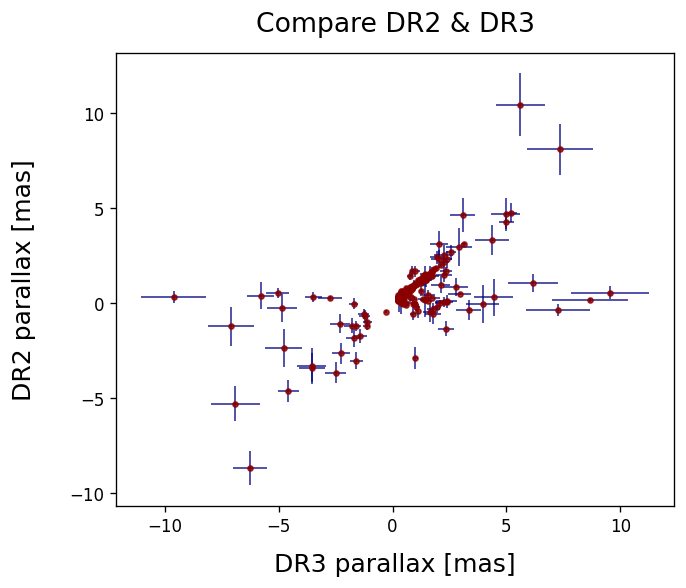

In [46]:
mask1 = mask2 = np.zeros(len(job3))
mask1[np.where(job3['dr2_parallax_error']==job3['dr2_parallax_error'][1])]=1
mask2[np.where(job3['dr2_parallax']==job3['dr2_parallax'][1])]=1
pr_dr3 = np.ma.array(job3['parallax'],mask=mask1)
prerr_dr3 = np.ma.array(job3['parallax_error'],mask=mask2)

pr_dr2 = job3['dr2_parallax']
prerr_dr2 = job3['dr2_parallax_error']
fig = plt.figure(figsize=(6,5),dpi=120)
plt.errorbar(x=pr_dr3,y=pr_dr2,yerr=prerr_dr2,xerr=prerr_dr3,fmt='.',
             color='darkred',ecolor='navy',linewidth=1,alpha=0.8)
plt.ylabel('DR2 parallax [mas]',fontsize=15,labelpad=20)
plt.title("Compare DR2 & DR3",fontsize=16,pad=13)
plt.xlabel('DR3 parallax [mas]',fontsize=15,labelpad=10)
plt.show()

### How much smaller are the DR3 parallax uncertainties on average?

In [47]:
print( "The DR3 parallax uncertainties are",np.mean(prerr_dr2)-np.mean(prerr_dr3),"smaller than DR2.")

The DR3 parallax uncertainties are 0.015508849173792444 smaller than DR2.


###  Explain what makes the parallax uncertainties change from DR2 to DR3 (see Brown et al., 2020).

## 15

### Plot period vs. absolute G-band magnitude for all stars returned by your query.

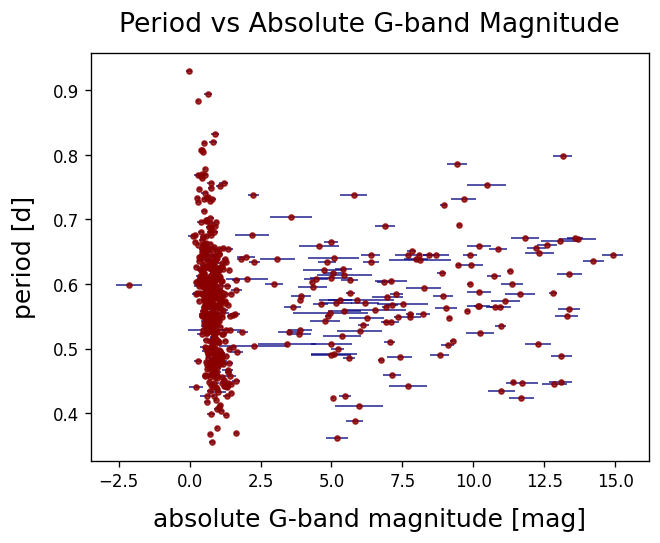

In [48]:
def plot_pf_GMag(job,data='dr3',label=None):
    pfs = job['pf']
    pferr = job['pf_error']
    if data=='dr3':
        abs_G_Mag = job['int_average_g']+5-5*np.log10(job['r_med_geo'])
        abs_G_Magerr = job['int_average_g_error']-5*(job['r_hi_geo'] - job['r_lo_geo'])/2/(job['r_med_geo']*np.log(10))
    if data=='dr2':
        abs_G_Mag = job['int_average_g']+5-5*np.log10(job['dr2_r_est'])
        abs_G_Magerr = job['int_average_g_error']-5*(job['dr2_r_hi'] - job['dr2_r_lo'])/2/(job['dr2_r_est']*np.log(10))

    fig = plt.figure(figsize=(6,4.5),dpi=120)
    plt.errorbar(x=abs_G_Mag,y=pfs,yerr=pferr,xerr=abs_G_Magerr,fmt='.',color='darkred',
                 ecolor='navy',linewidth=1,alpha=0.8,label=label)
    plt.ylabel('period [d]',fontsize=15,labelpad=10)
    plt.title("Period vs Absolute G-band Magnitude",fontsize=16,pad=13)
    plt.xlabel('absolute G-band magnitude [mag]',fontsize=15,labelpad=10)
    if label is not None:
        plt.legend()
    plt.show()

plot_pf_GMag(job=job3)

## 16 & 17

### Apply the quality cuts

In [49]:
from sklearn.neighbors import LocalOutlierFactor
import warnings
warnings.filterwarnings('ignore')

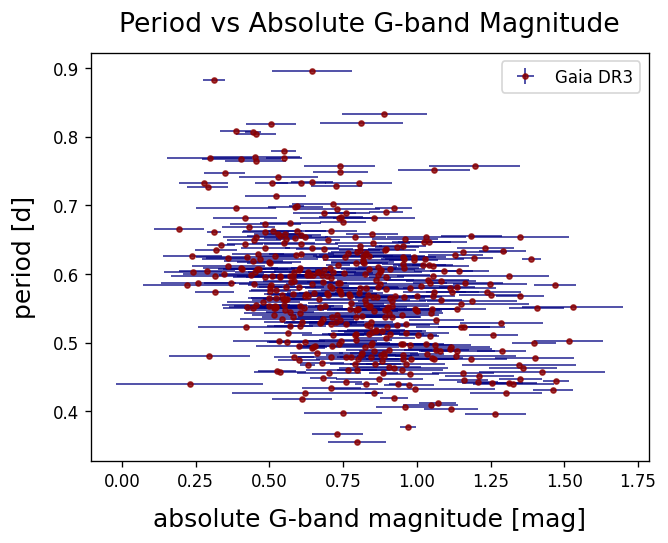

In [50]:
df = job3.to_pandas()

temps = []
for row in range(len(df)):
    temp = max(1,np.exp(-0.2*(df['phot_g_mean_mag'][row]-19.5)))
    temps.append(temp)
df['temps'] = temp
df = df.loc[(df['phot_bp_rp_excess_factor']<1.3+0.06*(df['bp_rp'])**2)&(df['phot_bp_rp_excess_factor']>1.0+0.015*(df['bp_rp'])**2)\
             &(np.sqrt(df['astrometric_chi2_al']/(df['astrometric_n_good_obs_al']-5))<1.2*df['temps'])]

df = df.drop(['temps'],axis=1)
abs_G_Mag = df['int_average_g']+5-5*np.log10(df['r_med_geo'])
pfs = df['pf']

model = LocalOutlierFactor(n_neighbors=25)
y_predict = model.fit_predict(np.array(abs_G_Mag).reshape(len(abs_G_Mag),1))
df = df.iloc[np.where(y_predict==1)]

job3 = Table.Table.from_pandas(df)

plot_pf_GMag(job=job3,label='Gaia DR3')

## 18

### For the same sample, try plotting based on Gaia DR2 parallaxes

In [51]:
query_3c =  '''SELECT ext.source_id,ext.r_est AS dr2_r_est,ext.r_lo AS dr2_r_lo,ext.r_hi AS dr2_r_hi
               FROM external.gaiadr2_geometric_distance as ext
               INNER JOIN gaiadr2.vari_rrlyrae as rr on rr.source_id = ext.source_id
               INNER JOIN gaiaedr3.dr2_neighbourhood as gaiadr23 on gaiadr23.dr2_source_id = rr.source_id
               INNER JOIN gaiaedr3.gaia_source as gaia3 on gaia3.source_id = gaiadr23.dr3_source_id
               WHERE abs(1/gaia3.parallax_over_error) < 0.2
               AND abs(gaia3.b) > 30
               AND abs(gaia3.parallax) > 0.25
               AND rr.pf IS NOT NULL'''

In [52]:
job3c = get_gaia_query(query_3c)

In [53]:
maskar = np.ma.array(np.zeros(len(job3)),mask=np.ones(len(job3)))
job3.add_columns([maskar,maskar,maskar],names=['dr2_r_est','dr2_r_lo','dr2_r_hi'])
for row in range(len(job3c)):
    nowid = job3c['source_id'][row]
    job3['dr2_r_est'][np.where(job3['source_id']==nowid)[0]]=job3c['dr2_r_est'][row]
    job3['dr2_r_lo'][np.where(job3['source_id']==nowid)[0]]=job3c['dr2_r_lo'][row]
    job3['dr2_r_hi'][np.where(job3['source_id']==nowid)[0]]=job3c['dr2_r_hi'][row]

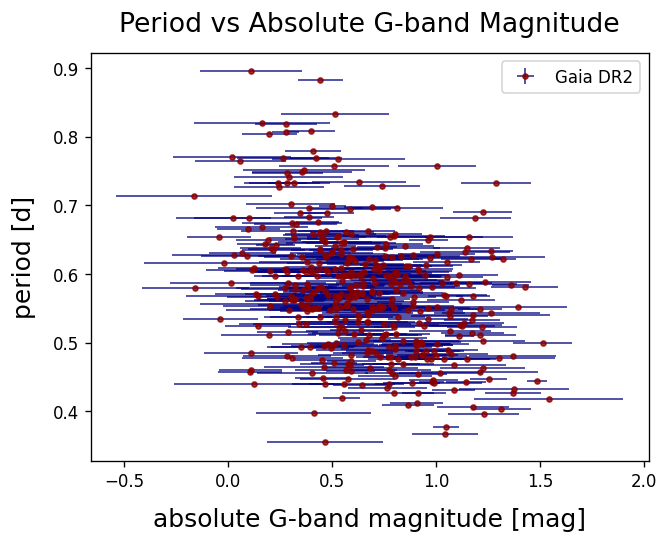

In [54]:
plot_pf_GMag(job=job3,data='dr2',label='Gaia DR2')

## 19

In [55]:
from scipy.stats import norm

In [56]:
def Gaussian_distribution(x,sigma=0.5,mu=1):
    y = norm.pdf(x, loc=mu, scale=sigma)
    return y

def MH_MCMC_sampler(N,target_sig=0.5,target_mu=1):
    pi = [0]*N
    target = 
    for t in range(N):
        pi_prime = norm.rvs(loc=pi[t], scale=1,size=1)
        alpha = min(1, (Gaussian_distribution(pi_prime)/Gaussian_distribution(pi[t])))
        u = random.uniform(0,1)
        
        if u<alpha:
            pi[t+1] = pi_prime
        else:
            pi[t+1] = pi[t]


SyntaxError: invalid syntax (<ipython-input-56-0febdeee076f>, line 7)

In [58]:
import pymc3


You can find the C code in this temporary file: C:\Users\admin\AppData\Local\Temp\theano_compilation_error_57c0_9rz


AttributeError: module 'theano' has no attribute 'gof'

In [78]:
norm.rvs(loc=pi[t], scale=1, random_state=5)

3.587294477009391

When intrinsic variance $\sigma^2_{scatter}$ follows Gaussian variance, the likelihood function is:

$$L(\theta) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi} \sigma} 
exp\left(-\frac{(y_i-\theta x_i)^2}{2\sigma ^2}\right)$$


Therefore the log likelihood is:

$$l(\theta) = -\frac{1}{2} \Sigma_{i=1}^n \left( \frac{(y_i-\theta x_i)^2}{\sigma ^2}
+ ln(2\pi\sigma^2)\right)$$

In [ ]:
def lnlike(theta, x, y):
    a, b, sig = theta
    model = a * x + b
    return -0.5*(np.sum((y-model)**2/sig**2 + np.log(2*np.pi*sig**2)))

def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [74]:
norm.rvs(loc=0, scale=sigma, size=1, random_state=1)

array([1.62434536])

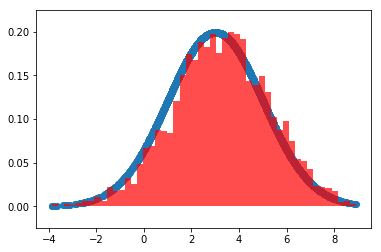

In [65]:
T = 5000
pi = [0 for i in range(T)]
sigma = 1
t = 0
while t < T-1:
    t = t + 1
    pi_star = norm.rvs(loc=pi[t - 1], scale=sigma, size=1, random_state=None)
    alpha = min(1, (norm_dist_prob(pi_star[0]) / norm_dist_prob(pi[t - 1])))

    u = random.uniform(0, 1)
    if u < alpha:
        pi[t] = pi_star[0]
    else:
        pi[t] = pi[t - 1]


plt.scatter(pi, norm.pdf(pi, loc=3, scale=2))
num_bins = 50
plt.hist(pi, num_bins, normed=1, facecolor='red', alpha=0.7)
plt.show()

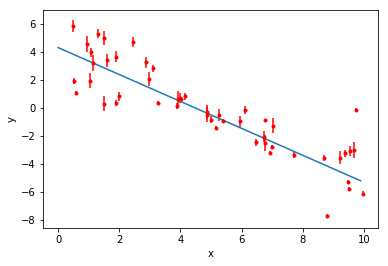

In [81]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
# import corner


def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

xfine = np.arange(0.0, 10, 0.1)
#yfit = [f(xx, popt[0], popt[1],popt[2]) for xx in xfine]
ytrue = [m_true*xx+b_true for xx in xfine]

plt.figure()
plt.errorbar(x, y, fmt='r.', yerr= yerr)
plt.plot(xfine, ytrue)
plt.xlabel('x')
plt.ylabel('y')
plt.show()